In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
plt.rc('text', usetex=True)
%matplotlib inline
from numba import jit

from time import time


import multiprocessing as mp

from scipy.interpolate import RectBivariateSpline

from ipywidgets import FloatProgress
from IPython.display import display

#from doublegyre import velocity_field

from numerical_integrators.single_step import euler, rk2, rk3, rk4

from numerical_integrators.adaptive_step import rkdp54, rkdp87

# Nødvendige for å opprette mapper om de ikke allerede eksisterer:
# (For lagring av advekterte tilstander)
import os
import errno

%load_ext line_profiler

In [ ]:
def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [ ]:
fixed_step_integrators = set(['euler', 'rk2', 'rk3', 'rk4'])

In [4]:
def grid_of_particles(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
        
    dx = wx / Nx
    dy = wy / Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    y, x = np.meshgrid(y0, x0)
    
    #pos = np.empty((2, Nx*Ny))
    
    #for j in range(Ny):
    #    pos[0,j*Nx:(j+1)*Nx] = x0
    #    pos[1,j*Nx:(j+1)*Nx] = y0[j]
    
    return np.array([x,y])

def grid_of_particles_for_transport(Nx, Ny = None, wx = 2, wy = 1):
    if Ny == None:
        Ny = np.round(Nx*wy/wx).astype(int)
    
    dx = wx/Nx
    dy = wy/Ny
    
    x0 = (np.arange(Nx) + 1/2) * dx
    y0 = (np.arange(Ny) + 1/2) * dy
    
    pos = np.empty((2, Nx * Ny))
    
    for j in range(Nx):
        pos[0, j*Ny:(j+1)*Ny] = x0[j]
        pos[1, j*Ny:(j+1)*Ny] = y0[:]
    
    return pos
    
@jit(nopython=True)                                                            
def doublegyre(t, x, A, e, w):                                              
    a = e * np.sin(w*t)                                                         
    b = 1 - 2*e*np.sin(w*t)                                                     
    f = a*x[0,:]**2 + b*x[0,:]                                                  
    v = np.empty(x.shape)                                                   
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:]) # x-component        
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*(2*a*x[0,:] + b) # y-component
    return v 
    
# Function wrapper to pass to the integrator.
# x is a two-component vector, x = [x_coord, y_coord]
@jit(nopython=True)
def vel(t, x):
    # Parameters of the velocity field:
    A = 0.1         # A
    e = 0.1         # epsilon
    w = 2*np.pi/10  # omega
    return doublegyre(t,x,A,e,w)

In [5]:
# ----
#      These functions advect particles with positions defined by meshgrids [X,Y]
# ----

def endpoints(t_min, t_max, pos, h, integrator, deriv, atol = None, rtol = None):
    if integrator.__name__ in fixed_step_integrators:
        return __endpoints_fixed(t_min, t_max, pos, h, integrator, deriv)
    else:
        return __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv, atol, rtol)


def __endpoints_fixed(t_min, t_max, pos, h, integrator, deriv, n_proc = 4):
    
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_fixed_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j])) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos
    
def __endpoints_fixed_slice(t_min, t_max, pos, h, integrator, deriv, q):
    t = t_min
    for j in range(np.ceil((t_max - t_min)/h).astype(int)):
        t, pos, h = integrator(t, pos, h, deriv)
    q.put(pos)

def __endpoints_adaptive(t_min, t_max, pos, h, integrator, deriv, atol, rtol, n_proc = 4):
    part = np.floor(np.size(pos,1) / n_proc).astype(int)
    
    queuelist = [mp.Queue() for j in range(n_proc)]
    
    processlist = [mp.Process(target = __endpoints_adaptive_slice, 
                             args = (t_min, t_max, 
                                    pos[:, j*part:-1 if j + 1 == n_proc else (j+1)*part], 
                                    h, integrator, deriv, queuelist[j], atol, rtol)) for j in range(n_proc)]

    for process in processlist:
        process.start()
        
    for j, queue in enumerate(queuelist):
        pos[:, j*part:-1 if j+1 == n_proc else (j+1)*part] = queue.get()
    
    for process in processlist:
        process.join()
    
    return pos

def __endpoints_adaptive_slice(t_min, t_max, pos, h, integrator, deriv, q, atol, rtol):
    t = np.ones(np.shape(pos[0]))*t_min
    h = np.ones(np.shape(t))*h
    
    while np.any(np.less(t, t_max)):
        h = np.minimum(h, t_max - t)
        t, pos, h = integrator(t, pos, h, deriv, atol, rtol)
        
    q.put(pos)

In [6]:
# ----
#      These functions advect main and auxiliary grids of particles, with coordinates 
#      given in long one-dimensional arrays rather than meshgrids.
#      Index 1: Grid "type", i.e., 0: Main
#                                  1: Aux. right
#                                  2: Aux. above
#                                  3: Aux. left
#                                  4: Aux. below
# ---- 

def endpoints_grid(t_min, t_max, pos, h, integrator, deriv, n_proc = 4, atol = None, rtol = None):
    part = np.floor(np.size(pos, 2) / n_proc).astype(int)
    queuelist = [mp.Queue() for j in range (n_proc)]
    if integrator.__name__ in fixed_step_integrators:
        processlist = [mp.Process(target = __endpoints_grid_fixed_slice, 
                                 args = (t_min, t_max, 
                                         pos[:,:,j*part:np.size(pos,2) if j + 1 == n_proc else (j+1)*part], 
                                         h, integrator, deriv, queuelist[j])) for j in range(n_proc)]
    else:
        processlist = [mp.Process(target = __endpoints_grid_adaptive_slice,
                                 args = (t_min, t_max, 
                                        pos[:,:,j*part:np.size(pos,2) if j + 1 == n_proc else (j+1)*part], 
                                        h, integrator, deriv, atol, rtol, queuelist[j])) for j in range(n_proc)]
    
    for process in processlist:
        process.start()
    for j, queue in enumerate(queuelist):
        pos[:,:,j*part:np.size(pos,2) if j + 1 == n_proc else (j+1)*part] = queue.get()
    for process in processlist:
        process.join()
    return pos

def __endpoints_grid_fixed_slice(t_min, t_max, pos, h, integrator, deriv, q):
    for j in range(5):
        stride = np.ones(np.size(pos,2)) * h
        t = np.ones(np.size(pos,2))*t_min
        while np.any(np.less(t, t_max)):
            stride = np.minimum(stride, t_max - t)
            t, pos[j,:,:], stride = integrator(t, pos[j,:,:], stride, deriv)
    q.put(pos)
    
def __endpoints_grid_adaptive_slice(t_min, t_max, pos, h, integrator, deriv, atol, rtol, q):
    for j in range(5):
        stride = np.ones(np.size(pos,2))*h
        t = np.ones(np.size(pos,2))*t_min
        h = np.minimum(h, t_max - t)
        while np.any(np.less(t, t_max)):
            stride = np.minimum(stride, t_max - t)
            t, pos[j,:,:], h = integrator(t, pos[j,:,:], h, deriv, atol, rtol)
            
    q.put(pos)
        

# Step 0: Check that the transport goes as planned

In [ ]:
Nx = 200
pos_init = grid_of_particles(Nx)

integrator = rk4

# Transport parameters:
t_min = 0
t_max = 20
h = 1

# Loop over grid and update all positions:
tic = time()
pos_fin = endpoints(t_min, t_max, pos_init, h, integrator, vel)
#pos_fin = endpoints(t_min, t_max, np.copy(pos_init), h, integrator, vel)
toc = time()

print('Transport took %.3f seconds' % (toc - tic))

In [ ]:
%lprun -f mp.Queue().get endpoints(t_min, t_max, np.copy(pos_init), h, integrator, vel)

In [ ]:
# Make a scatter plot to show grid points:
fig = plt.figure(figsize = (12,6), dpi = 200)
plt.scatter(pos_fin[0,:], pos_fin[1,:], lw = 0, marker = '.', s = 2)
plt.xlim(0, 2)
plt.ylim(0, 1)

In [ ]:
posr2 = np.copy(pos_fin)

In [ ]:
posr4 = np.copy(pos_fin)

In [ ]:
posr3 = np.copy(pos_fin)

In [ ]:
posr2[:,0]

In [ ]:
pos_init[-1,0]

In [ ]:
# Make a scatter plot to show grid points:
fig = plt.figure(figsize = (12,6), dpi = 200)
plt.scatter(pos_fin[0,:], pos_fin[1,:], lw = 0, marker = '.', s = 2)
plt.xlim(0, 2)
plt.ylim(0, 1)

# Step 1: Advect lots of particles

### ... including auxiliary grid points for independent improvement to spatial derivatives, following suite

In [294]:
# Choosing integrator:
integrator = rk4

# Create output directory for advected positions, if it does not already exist:
ensure_path_exists('advected_end_positions/{}'.format(integrator.__name__))

# Particle count in the x- and y-directions:
Nx = 200
Ny = 100

# ----
#      Main grid:
# ----
pos_init = grid_of_particles(Nx, Ny)

# Grid parameters, original grid:
dx = pos_init[0,-1,0] - pos_init[0,-2,0]
dy = pos_init[1,0,-1] - pos_init[1, 0, -2]

# ----
#      Transport parameters:
# ----

t_min = 0.
t_max = 20.
h = 0.05      # <--- Timestep, for fixed stepsize methods
tol = 1e-6    # <--- Tolerance, for adaptive stepsize methods 

# ----
#      Auxiliary grid spacing:
# ----

# Must be smaller (i.e., less than half) of that of the original grid
d = np.minimum(1e-5, dx*1e-2)

In [295]:
# If advection has already been performed previously, 
# load saved state.

# For fixed step integrators, the tolerance plays no role, and its value is thus not
# stored in the file names; similarly, the (initial) step length plays no _real_
# role for adaptive step size integrators, and is thus not stored in file names.

try:
    if integrator.__name__ in fixed_step_integrators:
        pos_fin = np.load('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        right_fin = np.load('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        left_fin = np.load('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        above_fin = np.load('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
        beneath_fin = np.load('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h))
    else:
        pos_fin = np.load('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        right_fin = np.load('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        left_fin = np.load('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        above_fin = np.load('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
        beneath_fin = np.load('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol))
    print('Configuration found! Advection not neccesary in this instance.')
except IOError:
    tic = time()
    grid_fin = endpoints_grid(t_min, t_max, np.array([grid_of_particles_for_transport(Nx,Ny),
                                                      grid_of_particles_for_transport(Nx,Ny) + np.array([d,0]).reshape(2,1), 
                                                      grid_of_particles_for_transport(Nx,Ny) + np.array([0,d]).reshape(2,1),
                                                      grid_of_particles_for_transport(Nx,Ny) + np.array([-d,0]).reshape(2,1),
                                                      grid_of_particles_for_transport(Nx,Ny) + np.array([0,-d]).reshape(2,1)]), 
                              h, integrator, vel, 4, tol, tol)
    toc = time()
    pos_fin = np.array([grid_fin[0,0].reshape(Nx,Ny), grid_fin[0,1].reshape(Nx,Ny)])
    right_fin = np.array([grid_fin[1,0].reshape(Nx,Ny), grid_fin[1,1].reshape(Nx,Ny)])
    above_fin = np.array([grid_fin[2,0].reshape(Nx,Ny), grid_fin[2,1].reshape(Nx,Ny)])
    left_fin = np.array([grid_fin[3,0].reshape(Nx,Ny), grid_fin[3,1].reshape(Nx,Ny)])
    beneath_fin = np.array([grid_fin[4,0].reshape(Nx,Ny), grid_fin[4,1].reshape(Nx,Ny)])


    
    
    print('Configuration not found! Advection was neccessary, elapsed time in integrating: {} seconds'.format(toc - tic))
    
    if integrator.__name__ in fixed_step_integrators:
        np.save('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), pos_fin)
        np.save('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), right_fin)
        np.save('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), left_fin)
        np.save('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), above_fin)
        np.save('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},h={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, h), beneath_fin)
    else:
        np.save('advected_end_positions/{}/main_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), pos_fin)
        np.save('advected_end_positions/{}/right_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), right_fin)
        np.save('advected_end_positions/{}/left_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), left_fin)
        np.save('advected_end_positions/{}/above_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), above_fin)
        np.save('advected_end_positions/{}/beneath_Nx={},Ny={},delta={},d={},t_min={},t_max={},tol={}.npy'.format(
                                        integrator.__name__, Nx, Ny, dx, d, t_min, t_max, tol), beneath_fin)
    
    print('Configuration now stored. Advection will not be necessary the next time the same parameters are used!')
    

Configuration found! Advection not neccesary in this instance.


# Step 2: Calculate derivatives of flow maps

### ... partly by use of auxiliary grid points

In [296]:
# [0,0]-component: dx/dx
# [0,1]-component: dx/dy
# [1,0]-component: dy/dx
# [1,1]-component: dy/dy

dF = np.empty((2, 2, Nx, Ny))
dF_a = np.copy(dF)

# Derivatives for auxiliary array:
# Centered differencing throughout
# dx/dx
dF_a[0,0,:,:] = (right_fin[0] - left_fin[0]) / (2*d)
# dx/dy
dF_a[0,1,:,:] = (above_fin[0] - beneath_fin[0]) / (2*d)
# dy/dx
dF_a[1,0,:,:] = (right_fin[1] - left_fin[1]) / (2*d)
# dy/dy
dF_a[1,1,:,:] = (above_fin[1] - beneath_fin[1]) / (2*d)

# Derivatives for main array:

# dx/dx
dF[0,0,0,:]    = (-3*pos_fin[0,0,:] + 4*pos_fin[0,1,:] - 2*pos_fin[0,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[0,0,1:-1,:] = (pos_fin[0,2:,:] - pos_fin[0,0:-2,:]) / (2*dx)                     # Centered differencing
dF[0,0,-1,:]   = (3*pos_fin[0,-1,:] - 4*pos_fin[0,-2,:] + 2*pos_fin[0,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dx/dy
dF[0,1,:,0]    = (-3*pos_fin[0,:,0] + 4*pos_fin[0,:,1] - 2*pos_fin[0,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[0,1,:,1:-1] = (pos_fin[0,:,2:] - pos_fin[0,:,0:-2]) / (2*dy)                     # Centered differencing
dF[0,1,:,-1]   = (3*pos_fin[0,:,-1] - 4*pos_fin[0,:,-2] + 2*pos_fin[0,:,-3]) / (2*dy) # 2nd order accurate backward differencing

# dy/dx
dF[1,0,0,:]    = (-3*pos_fin[1,0,:] + 4*pos_fin[1,1,:] - 2*pos_fin[1,2,:]) / (2*dx)   # 2nd order accurate forward differencing
dF[1,0,1:-1,:] = (pos_fin[1,2:,:] - pos_fin[1,0:-2,:]) / (2*dx)                     # Centered differencing
dF[1,0,-1,:]   = (3*pos_fin[1,-1,:] - 4*pos_fin[1,-2,:] + 2*pos_fin[1,-3,:]) / (2*dx) # 2nd order accurate backward differencing

# dy/dy
dF[1,1,:,0]    = (-3*pos_fin[1,:,0] + 4*pos_fin[1,:,1] - 2*pos_fin[1,:,2]) / (2*dy)   # 2nd order accurate forward differencing
dF[1,1,:,1:-1] = (pos_fin[1,:,2:] - pos_fin[1,:,0:-2]) / (2*dy)                     # Centered differencing
dF[1,1,:,-1]   = (3*pos_fin[1,:,-1] - 4*pos_fin[1,:,-2] + 2*pos_fin[1,:,-3]) / (2*dy) # 2nd order accurate backward differencing


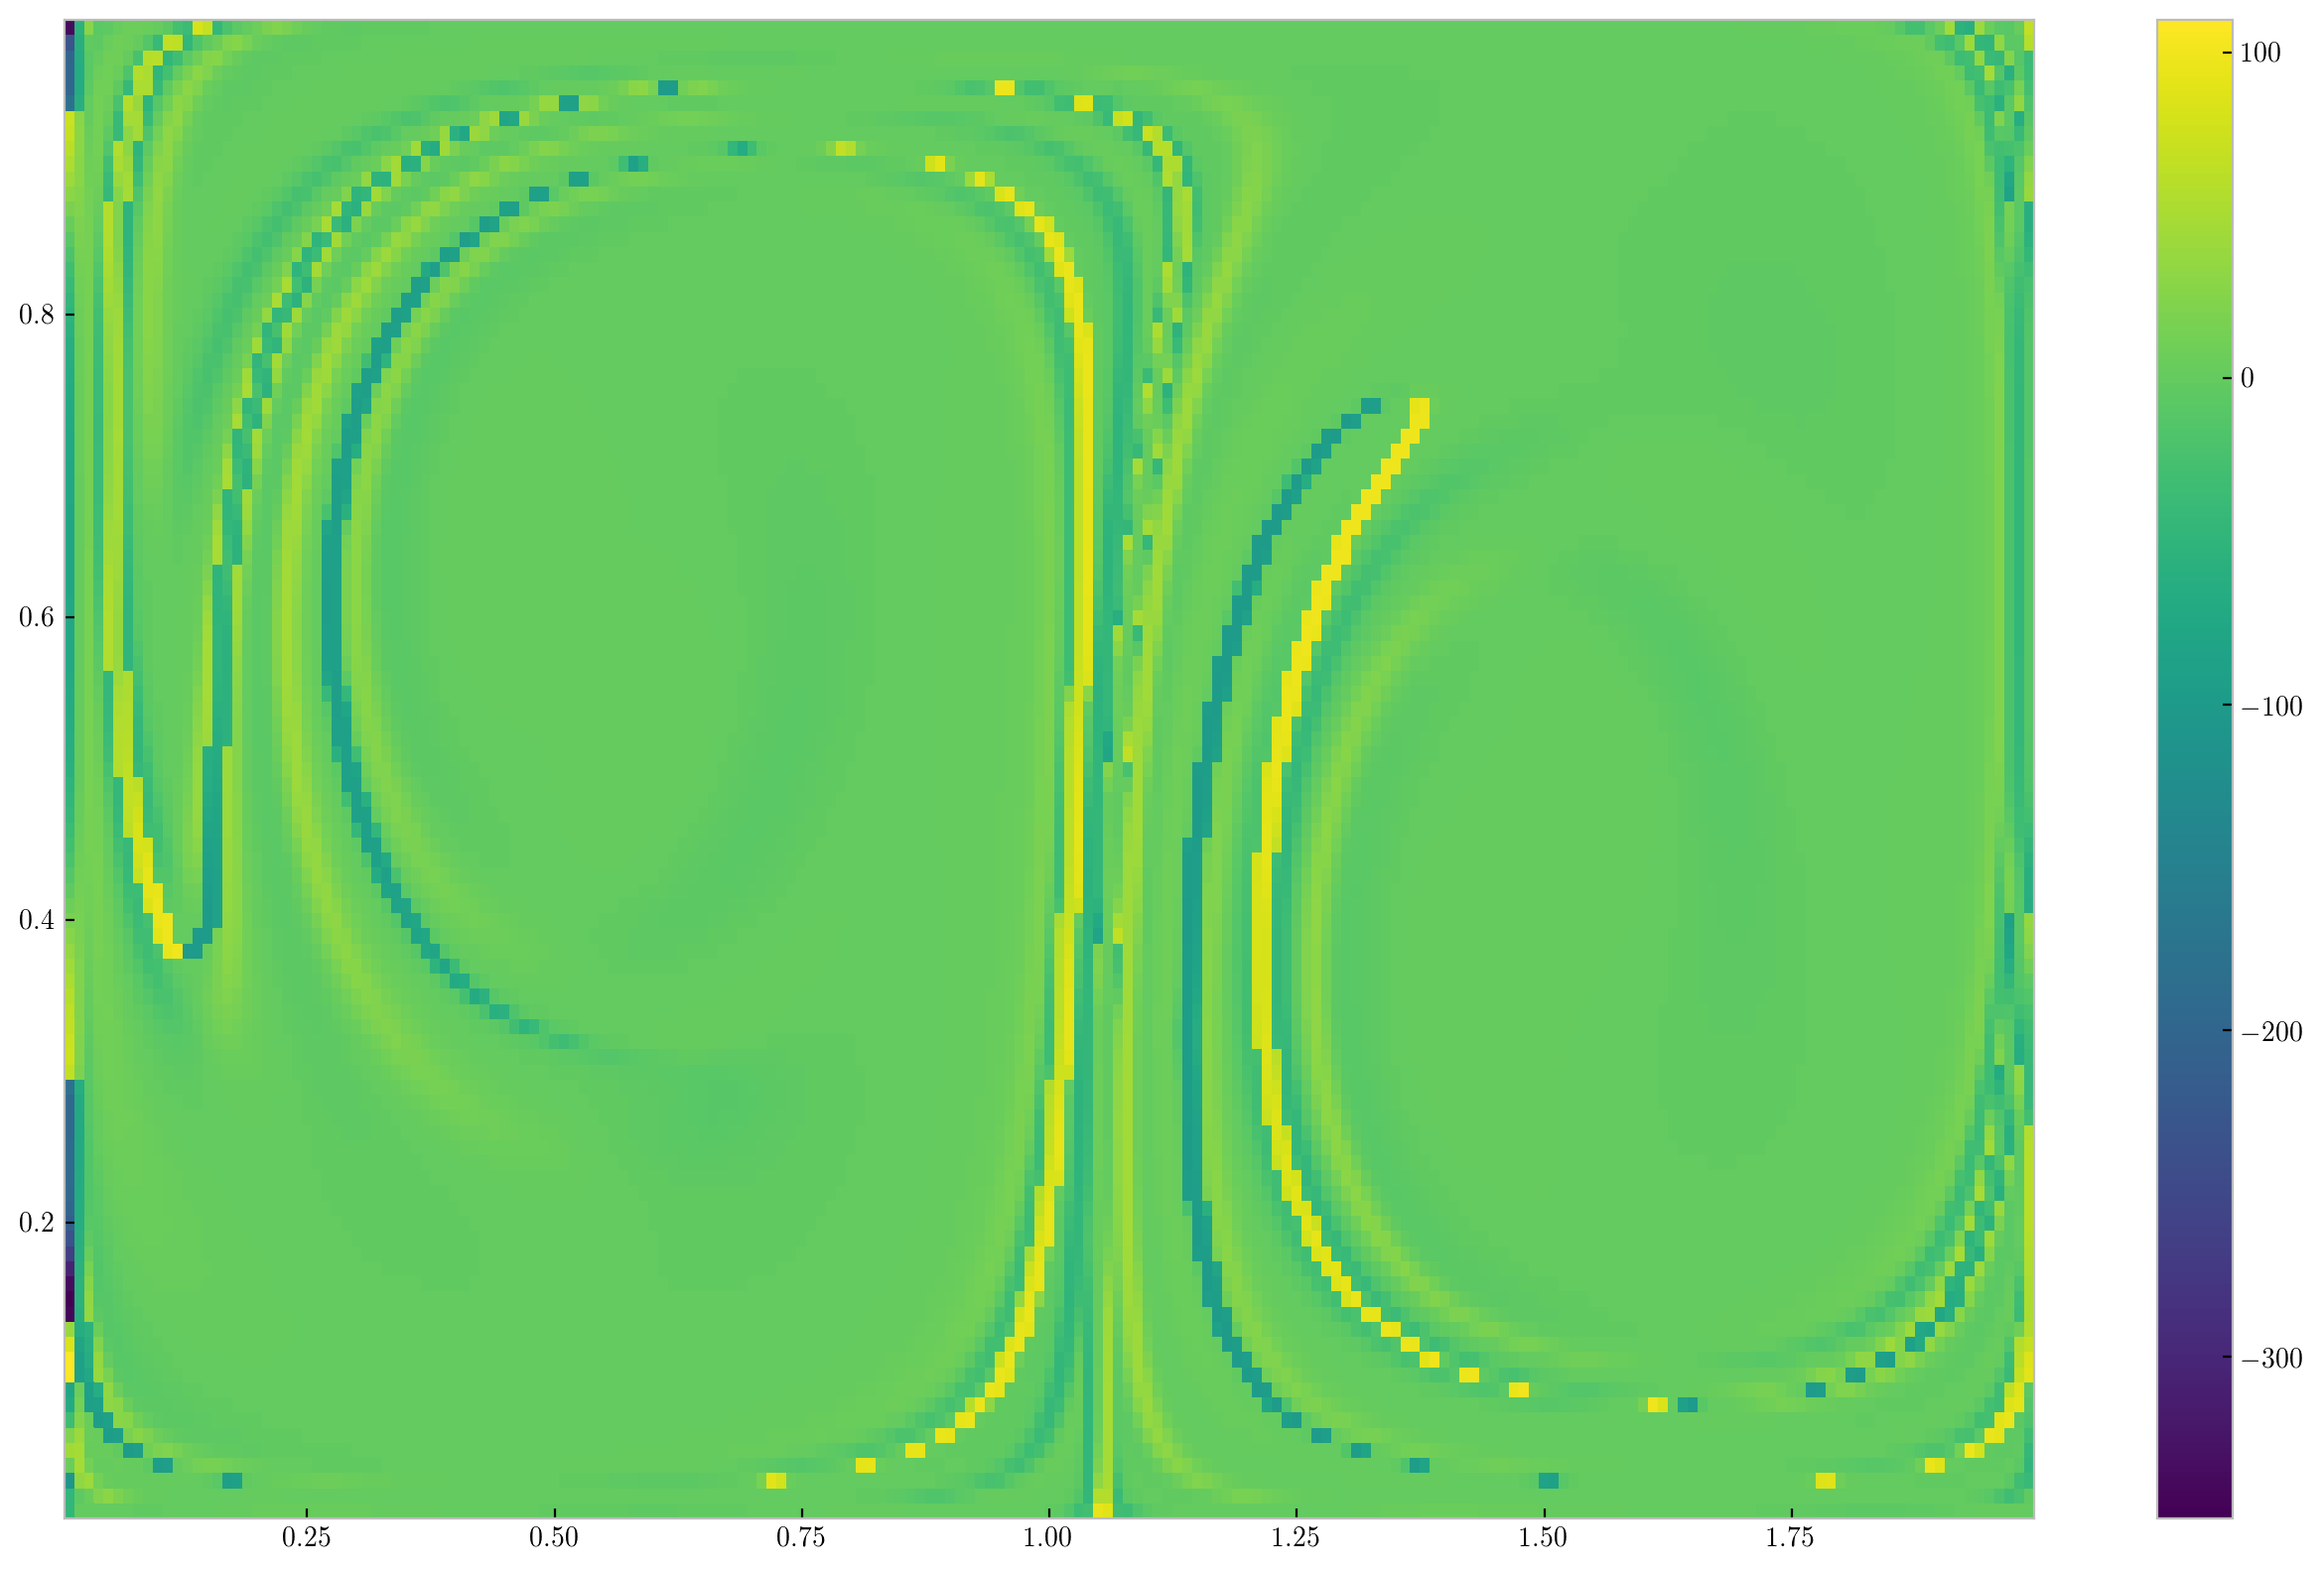

In [297]:
plt.figure(figsize = (16,10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], dF[0,0,:,:])
plt.colorbar(mesh)


# Step 3: Calculate Cauchy-Green strain tensors

In [298]:
C = np.empty(dF.shape)
C_a = np.empty(dF_a.shape)

assert dF.shape == dF_a.shape

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        C[:,:,i,j] = np.dot(dF[:,:,i,j].T, dF[:,:,i,j])
        C_a[:,:,i,j] = np.dot(dF_a[:,:,i,j].T, dF_a[:,:,i,j])

# Step 4: Calculate eigenvalues and -vectors of Cauchy-Green strain tensors

In [299]:
evals = np.empty((2, dF_a.shape[2], dF_a.shape[3]))
evecs = np.empty(C.shape)

evals_discard = np.copy(evals)
evecs_discard = np.copy(evecs)

for i in range(dF_a.shape[2]):
    for j in range(dF_a.shape[3]):
        vals, vecs = np.linalg.eigh(C[:,:,i,j])
        vals_a, vecs_a = np.linalg.eigh(C_a[:,:,i,j])
        
        idxvals = vals.argsort()[::-1]
        idxvals_a = vals_a.argsort()[::-1]
        
        evals[:,i,j] = vals[idxvals]
        evecs_discard[:,:,i,j] = vecs[:, idxvals]
        
        evals_discard[:,i,j] = vals_a[idxvals_a] 
        evecs[:,:,i,j] = vecs_a[:,idxvals_a]
        
# Element 0: Largest  eigenvalue and corresponding eigenvector
# Element 1: Smallest -------------------''-------------------

(0, 1)

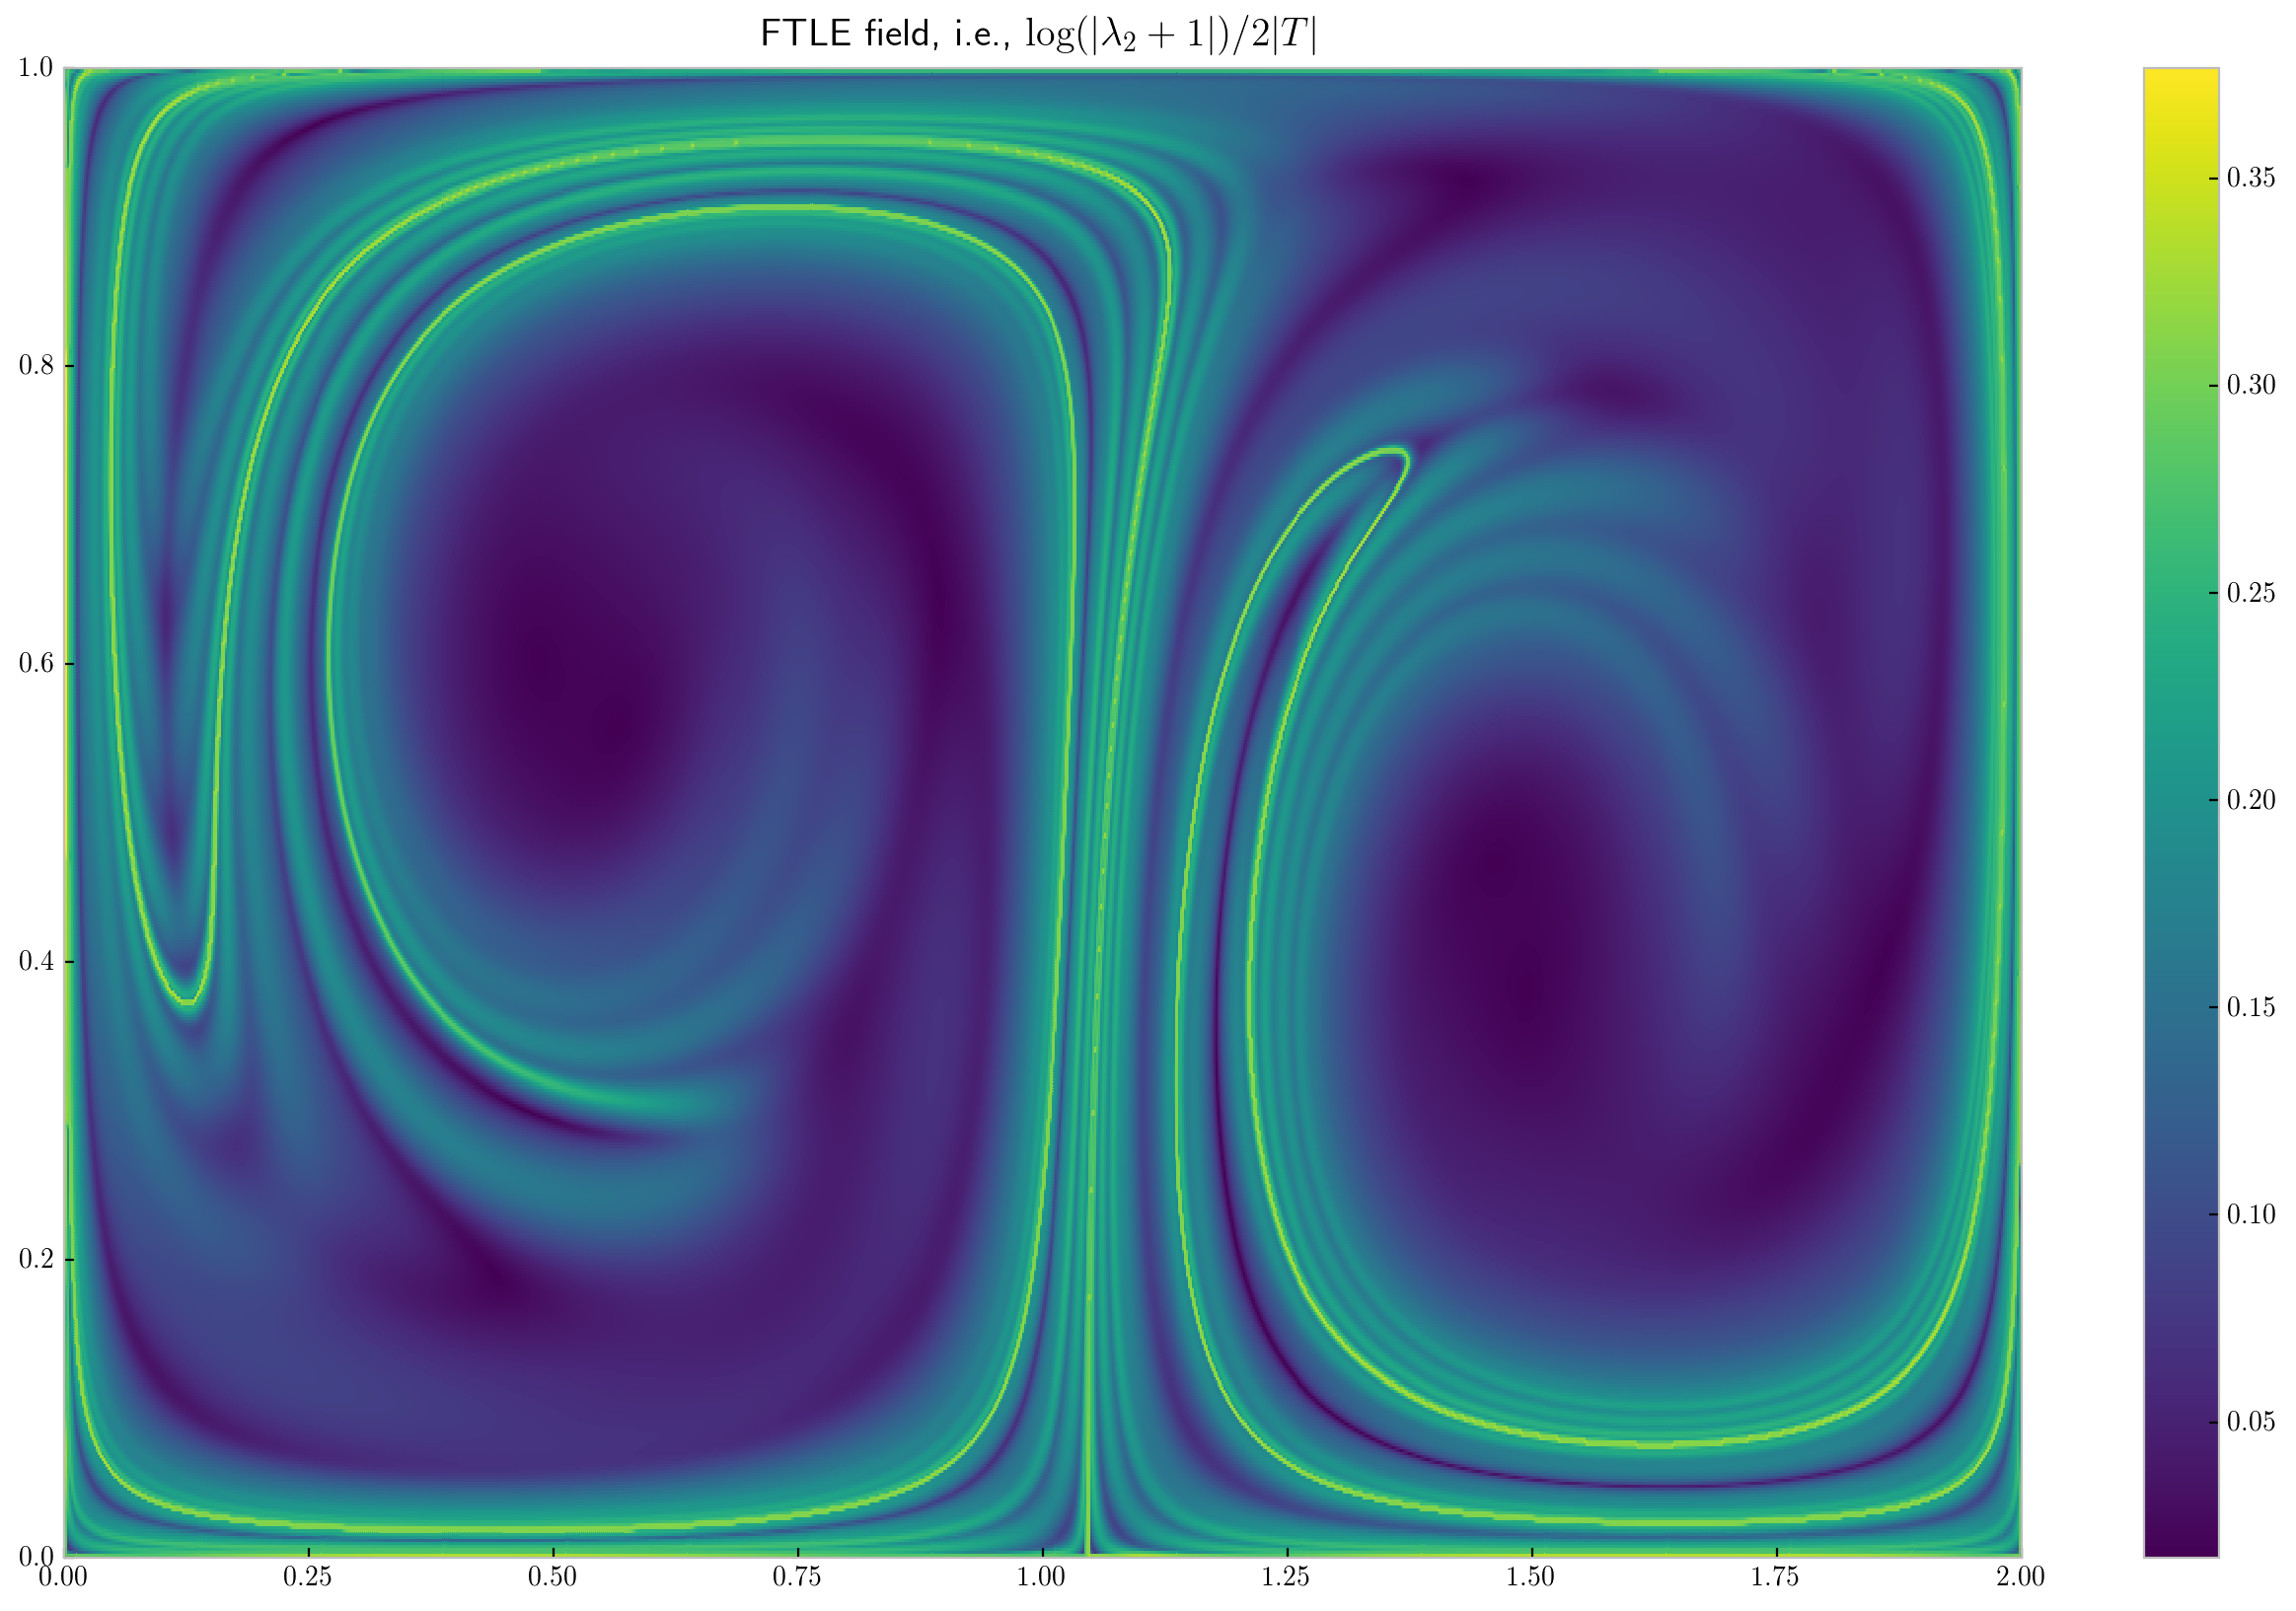

In [264]:
plt.figure(figsize = (16, 10), dpi = 200)
mesh = plt.pcolormesh(pos_init[0,:,:], pos_init[1,:,:], np.log(np.abs(evals[0,:,:] + 1)) / (2*np.abs(t_max - t_min)))
plt.colorbar(mesh)
plt.title(r'FTLE field, i.e., $\log(|\lambda_{2} + 1|) / 2|T|$')
plt.xlim(0,2)
plt.ylim(0,1)

# Step 5: Identify initial points belonging to $\mathcal{G}_{0}$

## i.e., the points for which conditions A and B hold:

### A: $\lambda_{1}(\mathbf{x}_{0}) \neq \lambda_{2}(\mathbf{x}_{0}) > 1 $
### B: $\langle \mathbf{\xi}_{2}(\mathbf{x}_{0}), \nabla^{2} \lambda_2(\mathbf{x}_0) \mathbf{\xi}_2(\mathbf{x}_0) \rangle \leq 0$

In [300]:
A_true = np.logical_and(np.not_equal(evals[0,:,:], evals[1,:,:]), np.greater(evals[0,:,:], 1))

In [301]:
# Find laplacian of largest eigenvector:
d2V = np.empty((Nx, Ny))

# Second derivative, x-direction:
d2V[0,:] = (2*evals[0,0,:] - 5*evals[0,1,:] + 4*evals[0,2,:] - evals[0,3,:])/(dx**2)      # Second order accurate forward difference
d2V[1:-1,:] = (evals[0,2:,:] - 2*evals[0,1:-1,:] + evals[0,0:-2,:])/(dx**2)             # Centered difference
d2V[-1,:] = (2*evals[0,-1,:] - 5*evals[0,-2,:] + 4*evals[0,-3,:] - evals[0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2V[:,0] += (2*evals[0,:,0] - 5*evals[0,:,1] + 4*evals[0,:,2] - evals[0,:,3])/(dy**2)     # Second order accurate forward difference
d2V[:,1:-1] += (evals[0,:,2:] - 2*evals[0,:,1:-1] + evals[0,:,0:-2])/(dy**2)            # Centered difference
d2V[:,-1] += (evals[0,:,-1] - 5*evals[0,:,-2] + 4*evals[0,:,-3] - evals[0,:,-4])/(dy**2)  # Second order accurate backward difference

inner = np.sum(evecs[:,0,:,:] * d2V * evecs[:,0,:,:], axis = 0)
B_true = np.less_equal(inner, 0)

In [302]:
# Find laplacian of product between largest eigenvector and -value:
d2VV = np.empty((2, Nx, Ny))

# Second derivative, x-direction:
d2VV[0,0,:] = (2*evals[0,0,:]*evecs[0,0,0,:] - 5*evals[0,1,:]*evecs[0,0,1,:] + 4*evals[0,2,:]*evecs[0,0,2,:] - evals[0,3,:]*evecs[0,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[0,1:-1,:] = (evals[0,2:,:]*evecs[0,0,2:,:] - 2*evals[0,1:-1,:]*evecs[0,0,1:-1,:] + evals[0,0:-2,:]*evecs[0,0,0:-2,:])/(dx**2)             # Centered difference
d2VV[0,-1,:] = (2*evals[0,-1,:]*evecs[0,0,-1,:] - 5*evals[0,-2,:]*evecs[0,0,-2,:] + 4*evals[0,-3,:]*evecs[0,0,-3,:] - evals[0,-4,:]*evecs[0,0,-4,:])/(dx**2) # Second order accurate backward difference

d2VV[1,0,:] = (2*evals[0,0,:]*evecs[1,0,0,:] - 5*evals[0,1,:]*evecs[1,0,1,:] + 4*evals[0,2,:]*evecs[1,0,2,:] - evals[0,3,:]*evecs[1,0,3,:])/(dx**2)      # Second order accurate forward difference
d2VV[1,1:-1,:] = (evals[0,2:,:]*evecs[1,0,2:,:] - 2*evals[0,1:-1,:]*evecs[1,0,1:-1,:] + evals[0,0:-2,:]*evecs[1,0,0:-2,:])/(dx**2)             # Centered difference
d2VV[1,-1,:] = (2*evals[0,-1,:]*evecs[1,0,-1,:] - 5*evals[0,-2,:]*evecs[1,0,-2,:] + 4*evals[0,-3,:]*evecs[1,0,-3,:] - evals[0,-4,:]*evecs[1,0,-4,:])/(dx**2) # Second order accurate backward difference

# Adding second derivative, y-direction:
d2VV[0,:,0] += (2*evals[0,:,0]*evecs[0,0,:,0] - 5*evals[0,:,1]*evecs[0,0,:,1] + 4*evals[0,:,2]*evecs[0,0,:,2] - evals[0,:,3]*evecs[0,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[0,:,1:-1] += (evals[0,:,2:]*evecs[0,0,:,2:] - 2*evals[0,:,1:-1]*evecs[0,0,:,1:-1] + evals[0,:,0:-2]*evecs[0,0,:,0:-2])/(dy**2)            # Centered difference
d2VV[0,:,-1] += (evals[0,:,-1]*evecs[0,0,:,-1] - 5*evals[0,:,-2]*evecs[0,0,:,-2] + 4*evals[0,:,-3]*evecs[0,0,:,-3] - evals[0,:,-4]*evecs[0,0,:,-4])/(dy**2)  # Second order accurate backward difference

d2VV[1,:,0] += (2*evals[0,:,0]*evecs[1, 0,:,0] - 5*evals[0,:,1]*evecs[1,0,:,1] + 4*evals[0,:,2]*evecs[1,0,:,2] - evals[0,:,3]*evecs[1,0,:,3])/(dy**2)     # Second order accurate forward difference
d2VV[1,:,1:-1] += (evals[0,:,2:]*evecs[1,0,:,2:] - 2*evals[0,:,1:-1]*evecs[1,0,:,1:-1] + evals[0,:,0:-2]*evecs[1,0,:,0:-2])/(dy**2)            # Centered difference
d2VV[1,:,-1] += (evals[0,:,-1]*evecs[1,0,:,-1] - 5*evals[0,:,-2]*evecs[1,0,:,-2] + 4*evals[0,:,-3]*evecs[1,0,:,-3] - evals[0,:,-4]*evecs[1,0,:,-4])/(dy**2)  # Second order accurate backward difference

inner2 = np.sum(evecs[:,0,:,:] * d2VV, axis = 0)

B_true2 = np.less_equal(inner2, 0)

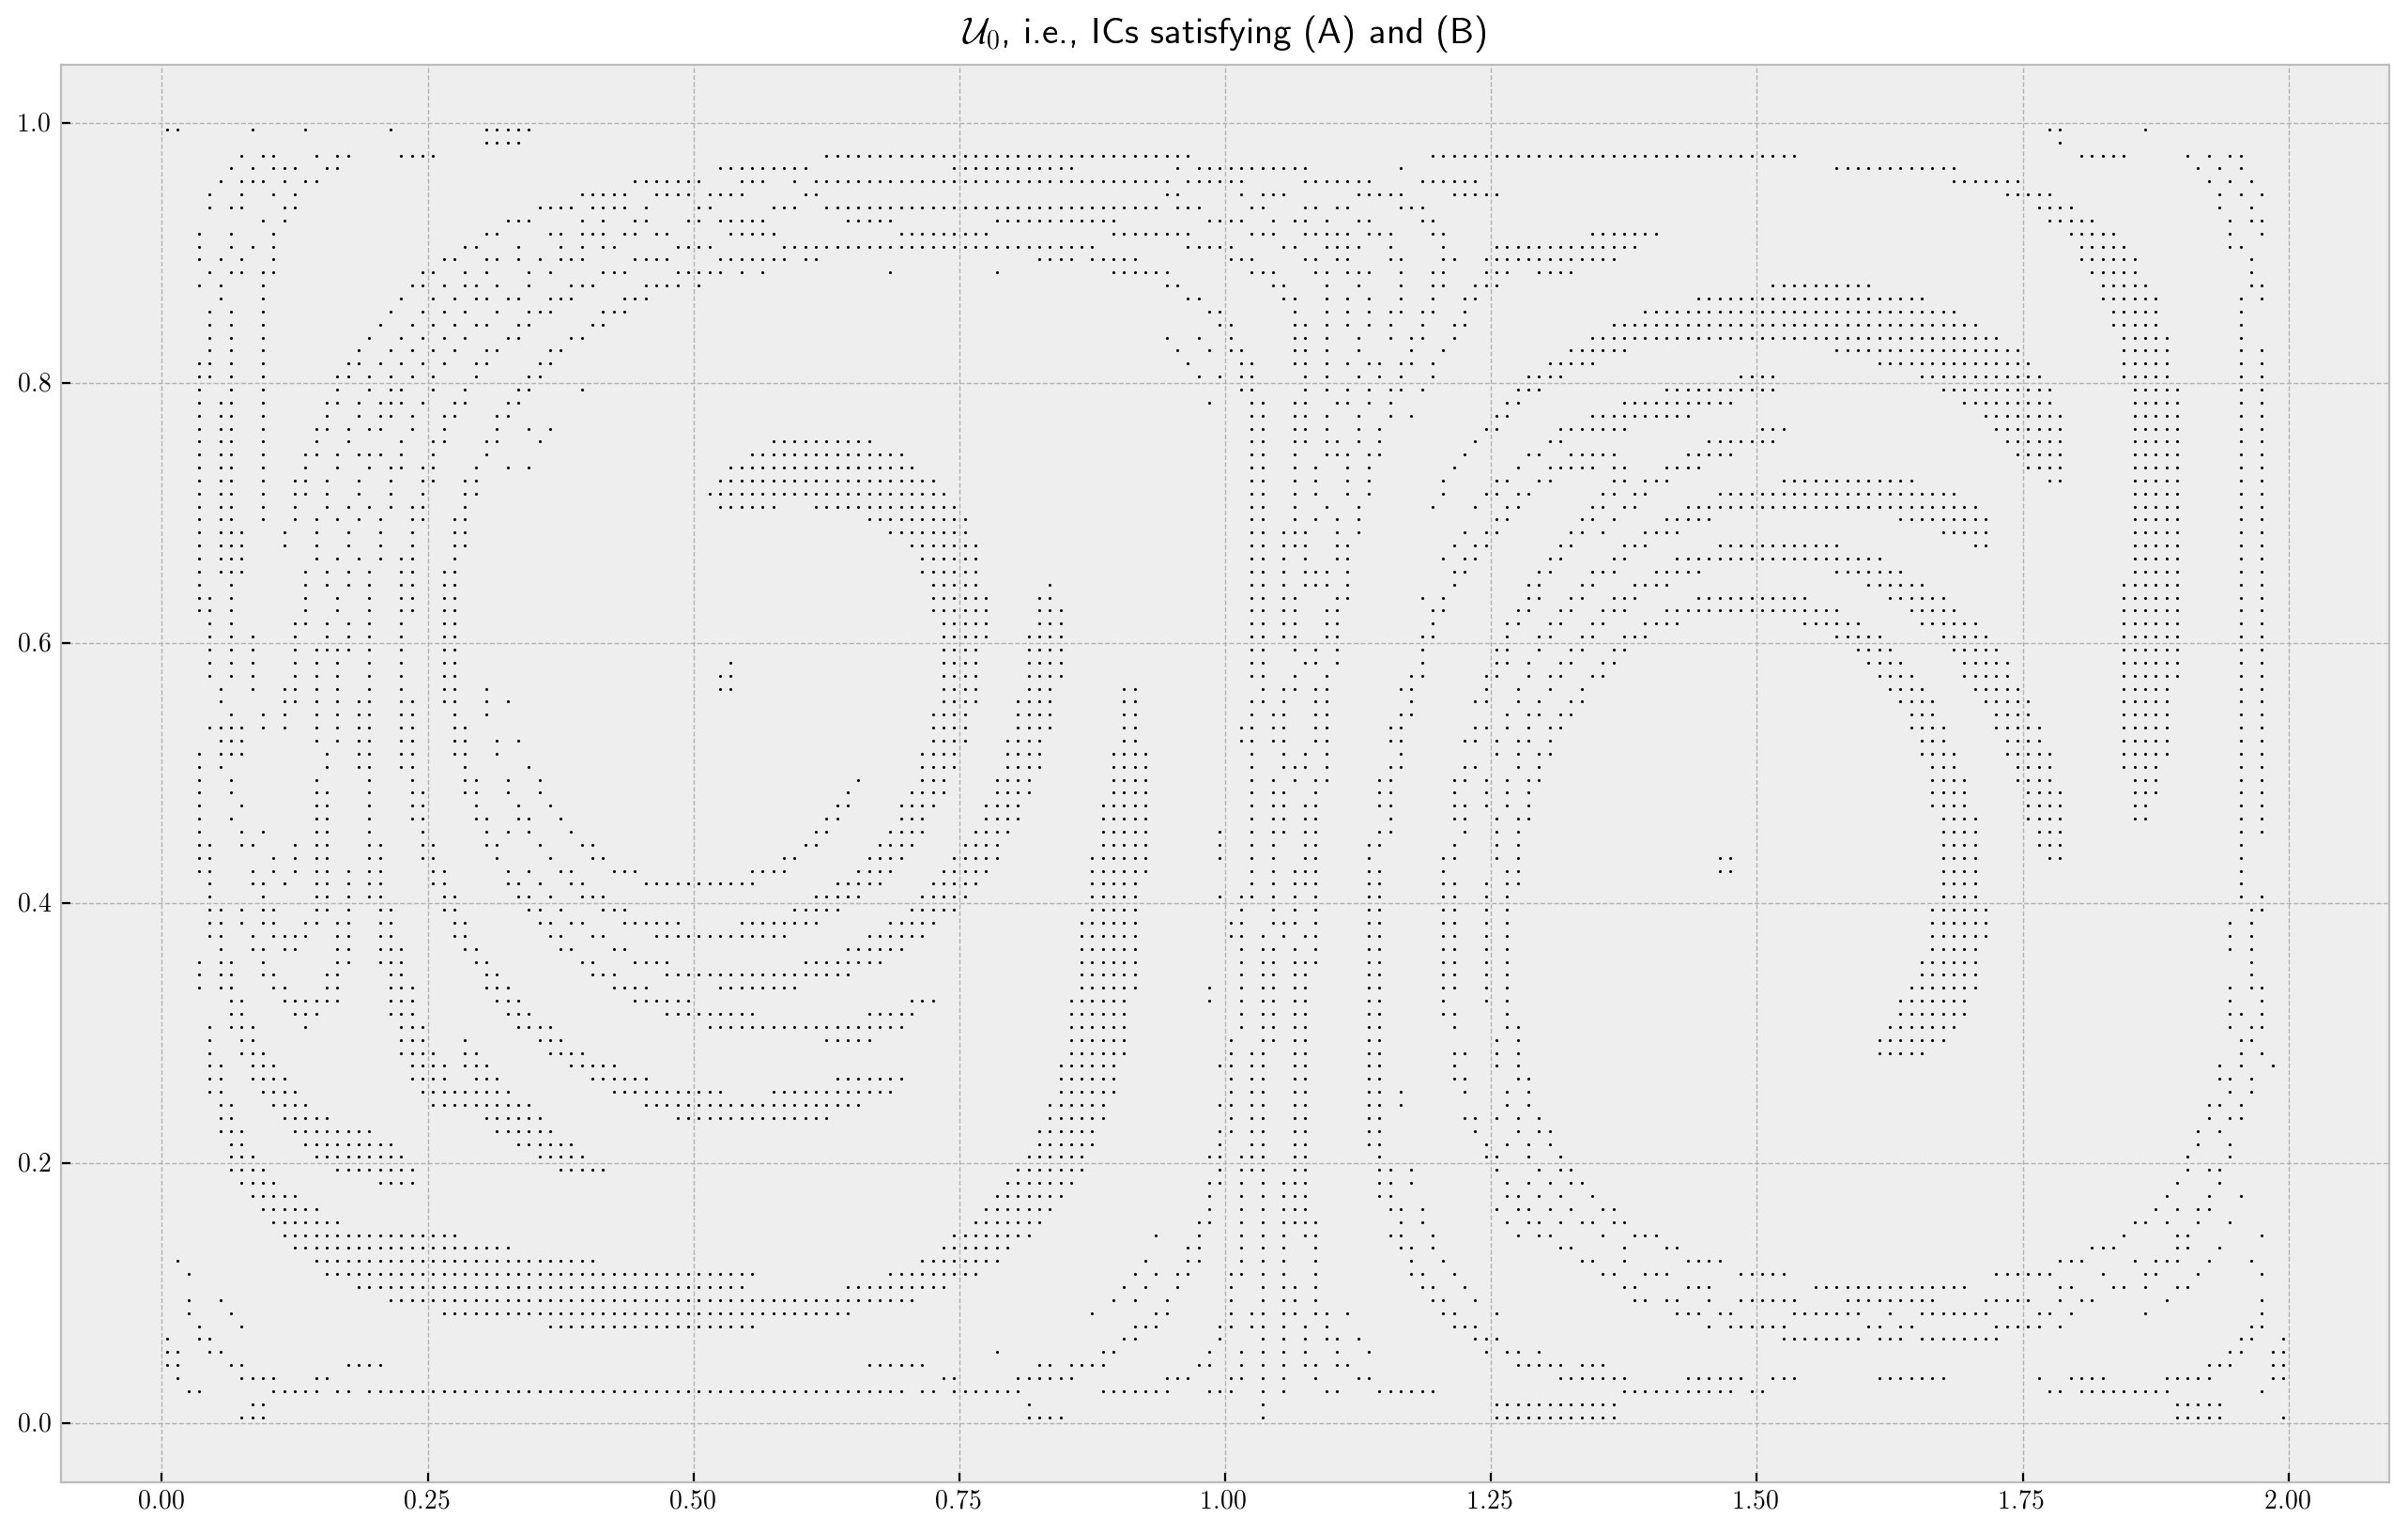

In [303]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], lw = 0, marker = '.', s = 5, color = 'k')
#plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue')
plt.title(r'$\mathcal{U}_{0}$, i.e., ICs satisfying (A) and (B)')

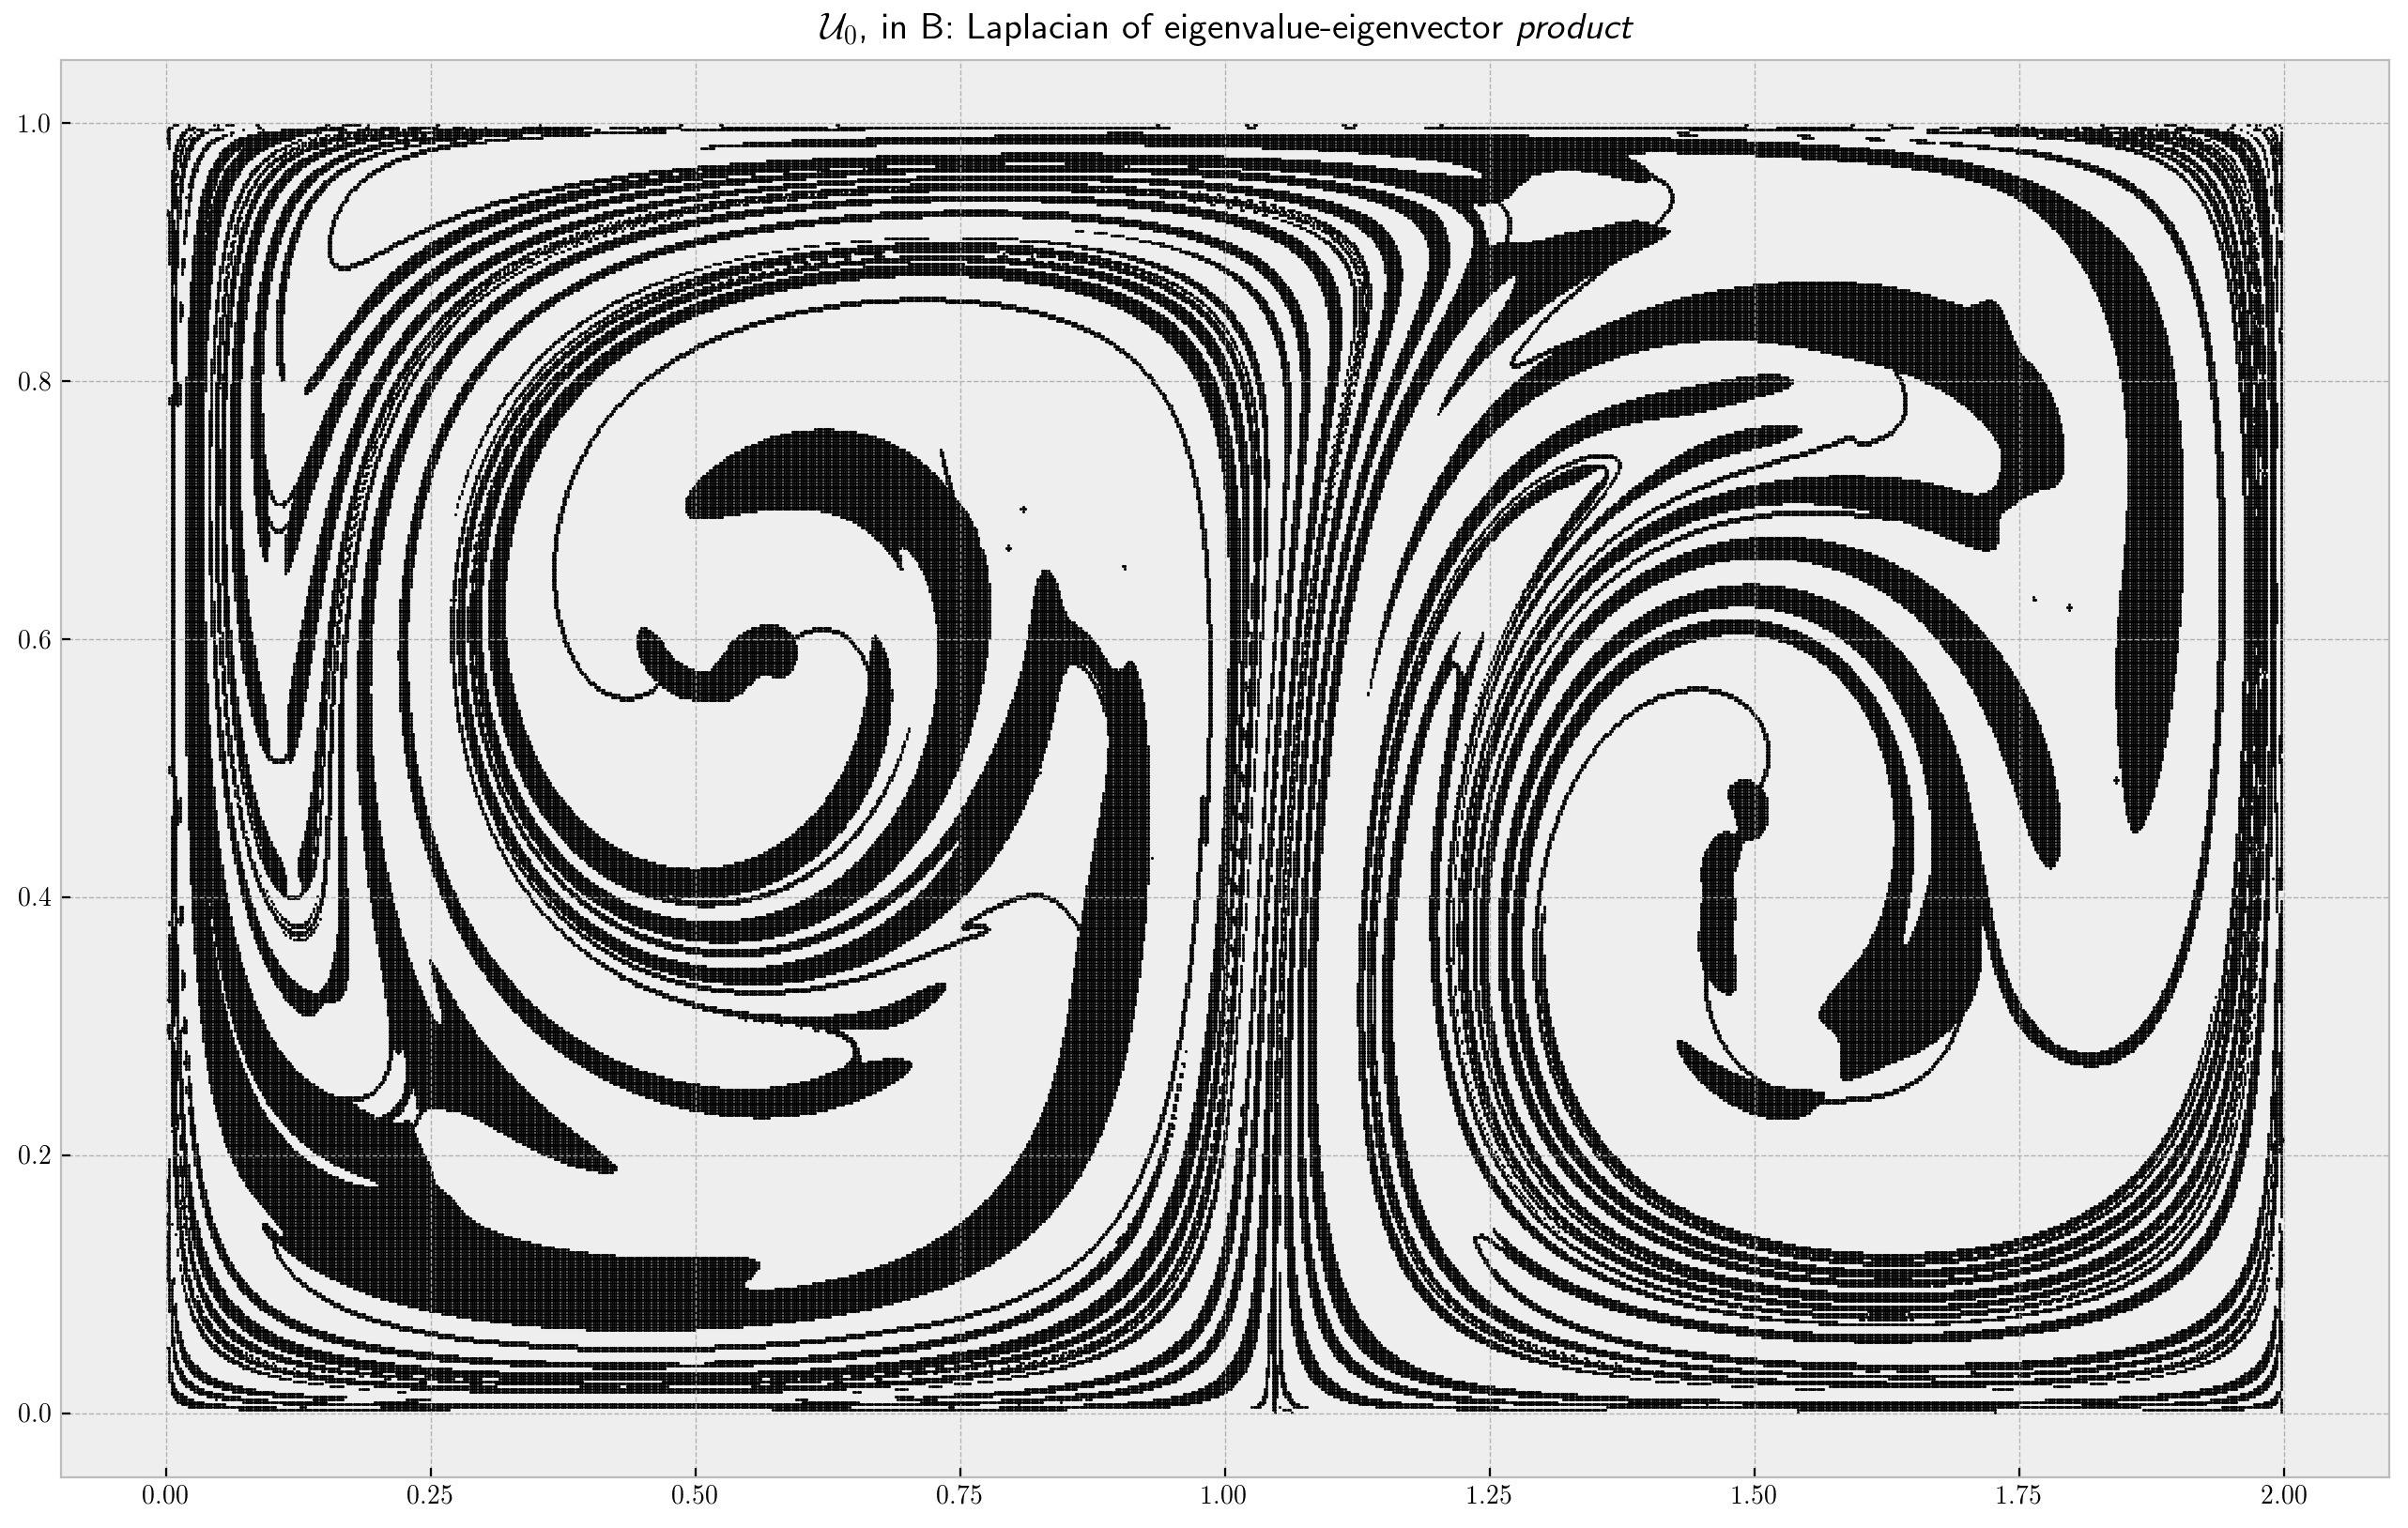

In [269]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true2)], pos_init[1,np.logical_and(A_true,B_true2)], lw = 0, marker = '.', s = 5, color = 'k')
plt.title(r'$\mathcal{U}_{0}$, in B: Laplacian of eigenvalue-eigenvector \emph{product}')

# Step 6: Choose subset $\mathcal{G}_{0}$, as the intersection of $\mathcal{U}_{0}$ and four vertical and horizontal lines

In [304]:
mask = np.zeros((Nx, Ny), dtype = np.bool)

for i in range(1,5):
    mask[:, np.minimum(int(i*Ny/5), Ny - 1)] = True
    mask[np.minimum(int(i*Nx/5), Nx - 1), :] = True
    
one_mask_to_rule_them_all = np.logical_and(mask, np.logical_and(A_true, B_true))    

G_0 = pos_init[:, one_mask_to_rule_them_all]

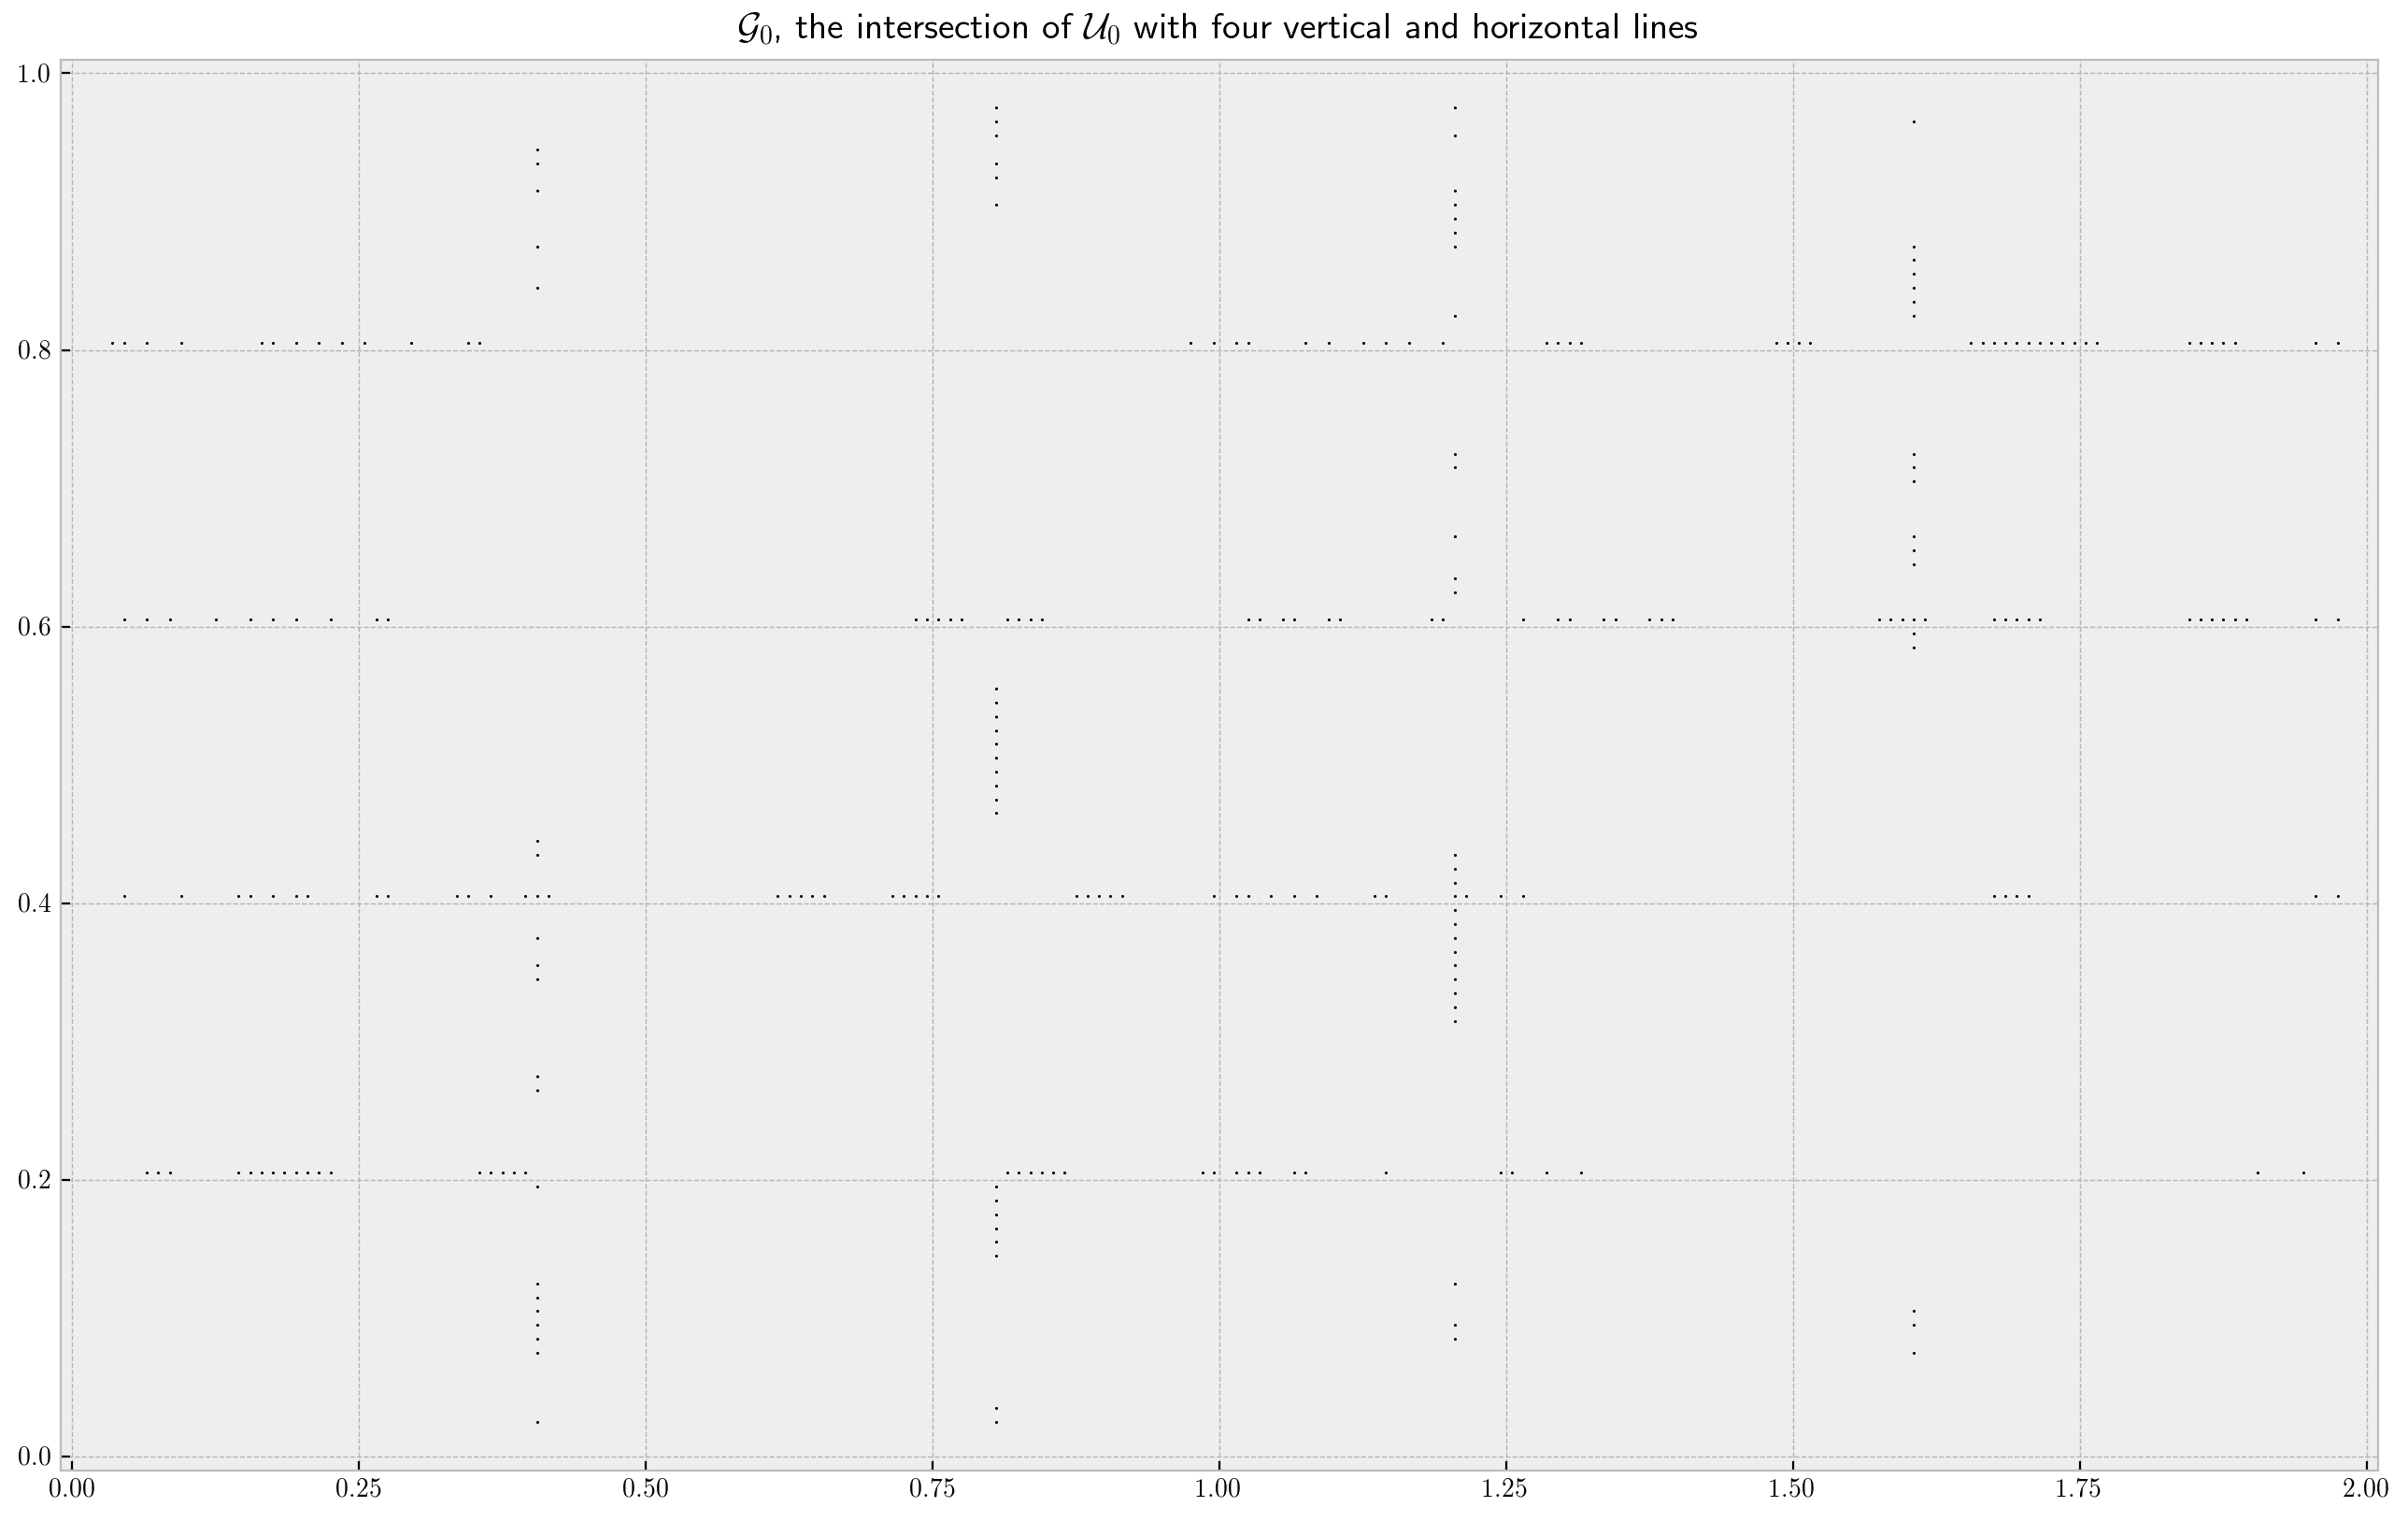

In [305]:
plt.figure(figsize = (16,10), dpi = 200)
plt.scatter(G_0[0], G_0[1], marker = '.', c = 'k', lw = 0, s = 5)
plt.xlim([-0.01, 2.01])
plt.ylim([-0.01, 1.01])
plt.title(r'$\mathcal{G}_{0}$, the intersection of $\mathcal{U}_{0}$ with four vertical and horizontal lines')

# Step 7: Define rescaled vector field from $\xi_{1}$ and advect the points in $\mathcal{G}_{0}$

## Using cubic splines:

In [306]:
lambda1_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[1,:,:].T, bbox = [0,1,0,2])
lambda2_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evals[0,:,:].T, bbox=[0,1,0,2])

xi1_x_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[0,1,:,:].T,bbox=[0,1,0,2])
xi1_y_spline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], evecs[1,1,:,:].T,bbox=[0,1,0,2])


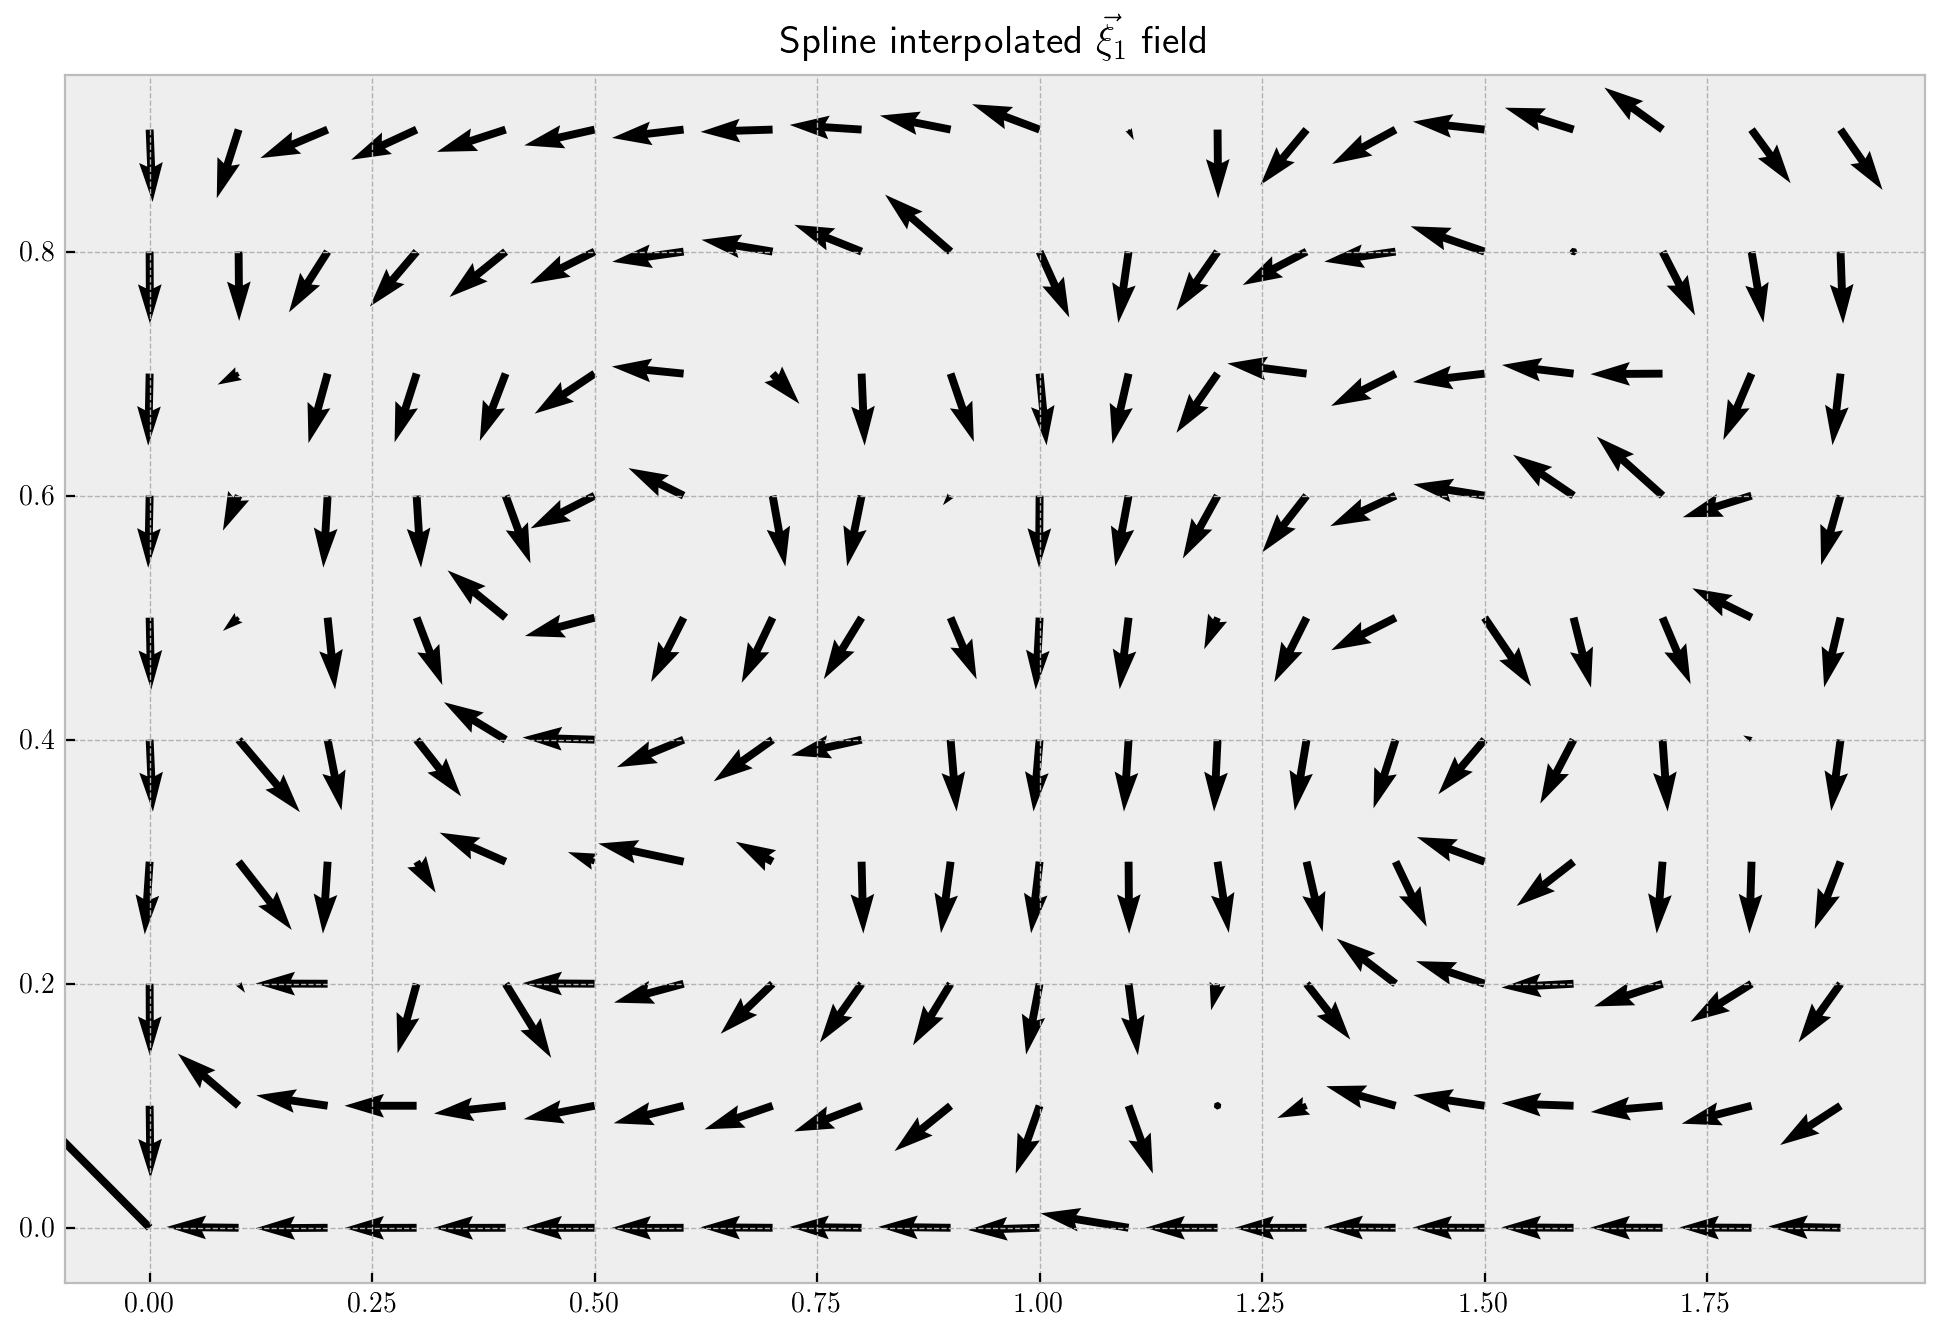

In [307]:
plt.figure(figsize = (12,8), dpi= 200)
plt.quiver(pos_init[0][::10,::10] - dx / 2, pos_init[1][::10,::10] - dy/2, xi1_x_spline.ev(pos_init[1] - dy/2, pos_init[0]  - dx/2)[::10,::10], xi1_y_spline.ev(pos_init[1] - dy/2, pos_init[0]  - dx/2)[::10,::10])
plt.title(r'Spline interpolated $\vec{\xi}_{1}$ field')

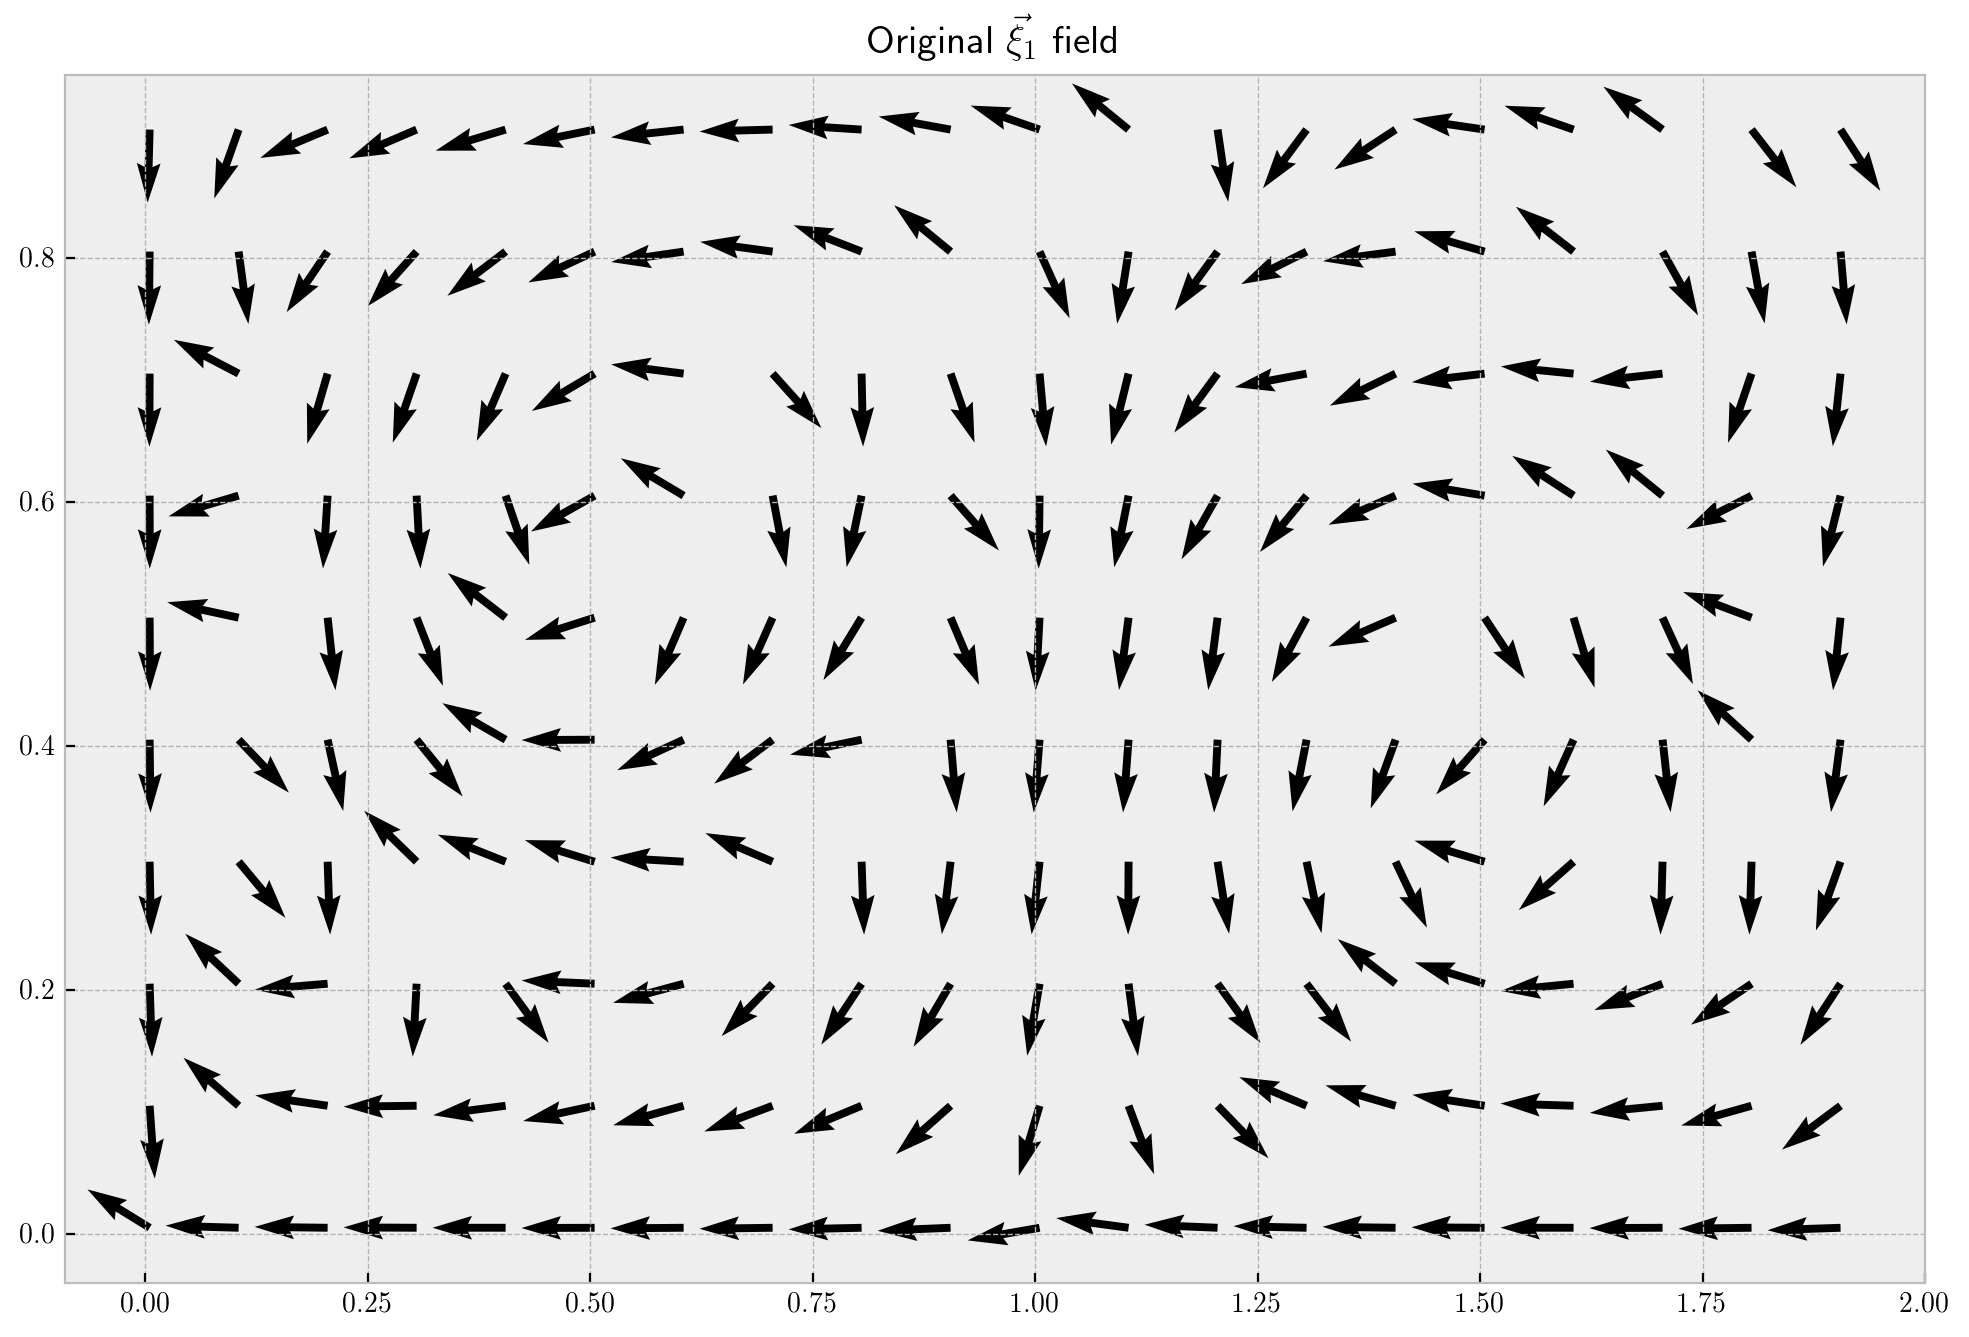

In [308]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0][::10,::10], pos_init[1][::10,::10], evecs[0,1][::10,::10], evecs[1,1][::10,::10])
plt.title(r'Original $\vec{\xi}_{1}$ field')

In [309]:
class Rescaled():
    def __init__(self, lambda1_spline, lambda2_spline, xi1_x_spline, xi1_y_spline):
        self.lambda1_spline = lambda1_spline
        self.lambda2_spline = lambda2_spline
        self.xi1_x_spline   = xi1_x_spline
        self.xi1_y_spline   = xi1_y_spline
        self.f_old = None
        
    def __call__(self, t, x):
        lambda1 = self.lambda1_spline.ev(x[1], x[0])
        lambda2 = self.lambda2_spline.ev(x[1], x[0])
        alpha = ((lambda2 - lambda1)/(lambda2 + lambda1))**2
        xi1_x = self.xi1_x_spline.ev(x[1], x[0])
        xi1_y = self.xi1_y_spline.ev(x[1], x[0])
        
        length = np.sqrt(xi1_x**2 + xi1_y**2)
        xi1_x /= length
        xi1_y /= length        
        
        f_new = alpha * np.array([xi1_x, xi1_y])
        

        
        if self.f_old is None:
            self.f_old = f_new
        
        sign = np.sign(np.dot(self.f_old, f_new))
        
#        self.f_old = f_new
        
        
        #sign = np.sign(np.sum(self.f_old * alpha * np.array([evec_x, evec_y])))
            

        return sign * f_new

In [310]:
class InAB():
    def __init__(self, AB_spline):
        self.AB_spline = AB_spline
        
    def __call__(self, x):
        return np.greater(self.AB_spline.ev(x[1],x[0]), 0.5)
    
class InDomain():
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
    def __call__(self, x):
        return np.logical_and(np.logical_and(np.less_equal(x[0], self.x_max), np.greater_equal(x[0], self.x_min)), np.logical_and(np.less_equal(x[1], self.y_max), np.greater_equal(x[1], self.y_min)))

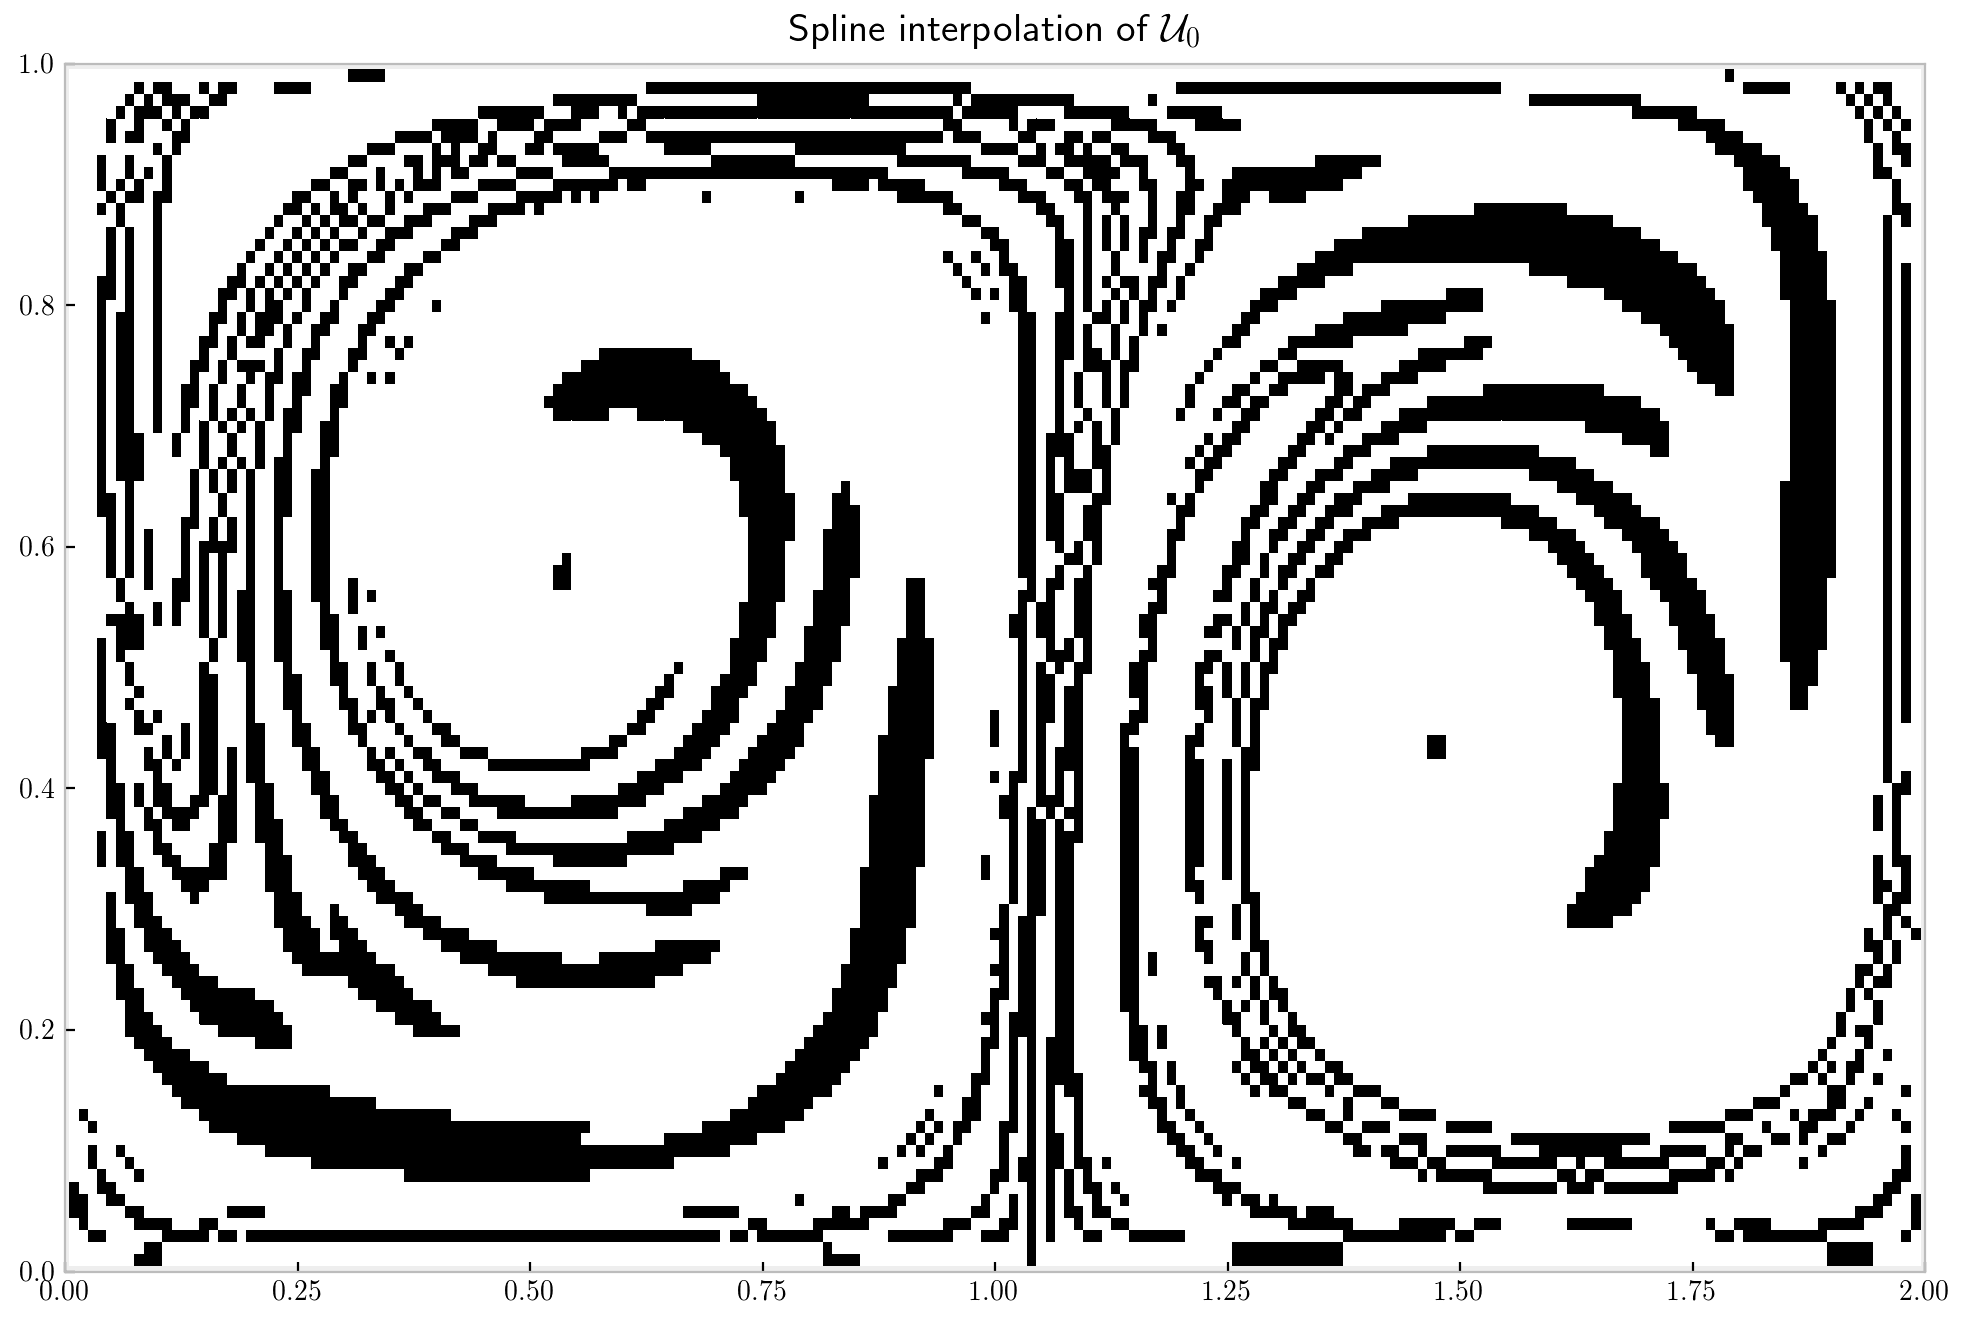

In [311]:
G = np.copy(G_0)

AB_spline = RectBivariateSpline(pos_init[1, 0, :], pos_init[0, :, 0], np.logical_and(A_true, B_true).T)

inAB = InAB(AB_spline)

inDomain = InDomain(x_min = 0, x_max = 2, y_min = 0, y_max = 1)

plt.figure(figsize = (12, 8), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], inAB(pos_init), cmap = 'gray_r')
plt.xlim(0,2)
plt.ylim(0,1)
plt.title(r'Spline interpolation of $\mathcal{U}_{0}$')

In [312]:
np.sum(inAB(pos_init))

5280

In [313]:
class Strainline():
    def __init__(self,pos_init, lambda1_spline, lambda2_spline):
        self.pos = [pos_init.T]
        self.continious_failure = False
        self.is_long_enough = False
        self.lambda1_spline = lambda1_spline
        self.lambda2_spline = lambda2_spline
    #    self.is_strainline = True
    
    def __call__(self):
        return np.asarray(self.pos[-1])
    
    def has_failed_continuity(self):
        return self.continious_failure
    
    def failed_continuity(self):
        self.continious_failure = True
        
    def sufficient_length(self):
        self.is_long_enough = True
    
    #def
    
    #def is_not(self):
    #    self.is_strainline = False
    
    def is_strainline(self):
        return np.logical_and(self.is_long_enough, np.logical_not(self.continious_failure))
    
    def append(self, pos):
        self.pos.append(pos.T)
        
    def get_average_lambda2(self):
        return np.mean(self.lambda2_spline.ev(np.asarray(self.pos)[1], np.asarray(self.pos)[0]))
    
    def get_entire_trajectory(self):
        return np.asarray(self.pos)

In [314]:
f = Rescaled(lambda1_spline, lambda2_spline, xi1_x_spline, xi1_y_spline)

In [315]:
def advect_strainlines(strainlines, max_iter, stride, l_f_max, l_min, inDomain, inAB, rescaled, pn, q):
    for count, strainline in enumerate(strainlines):
        rescaled.f_old = None
        t = 0.
        i = 0.
        L = 0.
        L_f = 0.
        rescaled.f_old = rescaled(t, strainline())
        bar = rescaled(t, strainline())
        foo, tmp, stride = integrator(t, strainline(), stride, rescaled)
        i += 1
        while np.logical_and(np.logical_and(np.less(i, max_iter), inDomain(tmp)), np.logical_not(strainline.has_failed_continuity())):
            if np.greater(foo, t):
                L += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
                if np.logical_not(inAB(tmp)):
                    L_f += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
                else:
                    L_f = 0.
                rescaled.f_old = bar
                t = foo
                strainline.append(tmp)
                if np.greater(L_f, l_f_max):
                    strainline.failed_continuity()
                i+=1
            bar = rescaled(t, strainline())
            foo, tmp, stride = integrator(t, strainline(), stride, rescaled)
        if np.greater(L, l_min):
            strainline.sufficient_length()
        if np.logical_not(np.mod(count+1, 10)):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn, count, np.size(strainlines)))
            
    q.put(strainlines)

In [316]:
import time

In [317]:
strainlines = [Strainline(G[:,j], lambda1_spline, lambda2_spline) for j in range(np.size(G,1))]

max_iter = 40000
stride = 0.0005
l_f_max = 0.2
l_min = 1

tic = time.time()

part = np.floor(np.size(strainlines)/4).astype(int)

queuelist = [mp.Queue() for j in range(4)]
processlist = [mp.Process(target = advect_strainlines, 
                          args = (strainlines[j*part:np.size(strainlines) if j + 1 == 4 else (j+1)*part], 
                                 max_iter, stride, l_f_max, l_min, inDomain, inAB, f, j, queuelist[j])) for j in range(4)]

for process in processlist:
    process.start()
for j, queue in enumerate(queuelist):
    strainlines[j*part:np.size(strainlines) if j + 1 == 4 else (j+1)*part] = queue.get()
for process in processlist:
    process.join()
toc = time.time()

print('Elapsed time for advection: {} seconds'.format(toc-tic))

    
#for count, strainline in enumerate(strainlines):
#    f.f_old = None
#    t = 0.
#    i = 0
#    L = 0.
#    L_f = 0.
#    while np.logical_and(np.logical_and(np.less(i, max_iter), inDomain(strainline())), np.logical_not(strainline.has_failed_continuity())):
#        foo, tmp, stride = integrator(t, strainline(), stride, f)
#        if np.greater(foo, t):
#            L += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
#            if np.logical_not(inAB(tmp)):
#                #prev = strainline()
#                L_f += np.sqrt((strainline()[0] - tmp[0])**2 + (strainline()[1] - tmp[1])**2)
#            else:
#                L_f = 0.
#            f.f_old = f(t,strainline())
#            t = foo
#            strainline.append(tmp)
#            if np.greater(L_f, l_f_max):
#                strainline.failed_continuity()
#            i += 1
#        
#    if np.greater(L, l_min):
#        strainline.sufficient_length()
#    if np.logical_not(np.mod(count, 100)):
#        print('Finished integrating strainline candidate {} of {}'.format(count, np.size(strainlines)))
                
        
    

#a = strainlines[0]

#a.append(np.asarray([-1, -1]))
#b = a()
#b

Process 1: Finished integrating strainline candidate 9 of 69
Process 3: Finished integrating strainline candidate 9 of 71
Process 0: Finished integrating strainline candidate 9 of 69
Process 1: Finished integrating strainline candidate 19 of 69
Process 2: Finished integrating strainline candidate 9 of 69
Process 0: Finished integrating strainline candidate 19 of 69
Process 2: Finished integrating strainline candidate 19 of 69
Process 3: Finished integrating strainline candidate 19 of 71
Process 1: Finished integrating strainline candidate 29 of 69
Process 1: Finished integrating strainline candidate 39 of 69
Process 3: Finished integrating strainline candidate 29 of 71
Process 0: Finished integrating strainline candidate 29 of 69
Process 3: Finished integrating strainline candidate 39 of 71
Process 0: Finished integrating strainline candidate 39 of 69
Process 1: Finished integrating strainline candidate 49 of 69
Process 1: Finished integrating strainline candidate 59 of 69
Process 2: F

In [ ]:
real_

In [ ]:
a.pos

In [189]:
real_candidates = []

for strainline in strainlines:
    if strainline.is_strainline():
        real_candidates.append(strainline)

In [191]:
for cand in real_candidates:
    print(cand.get_average_lambda2())

772.547036545
159.324296172
223.553988667
51.0060056428
54.5020566597
234.012048135
56.3143351112
233.38679946
20.7240899068
29.919379236
3664.30750937
1098.34967603
6853.79329859
7607.22281979
7707.65627725
13039.9828513
13556.7008237
13556.9309087
14103.8994429


In [286]:
j = 0

for strainline in strainlines:
    if strainline.has_failed_continuity():
        j+=1
        
print(j)

1101


In [287]:
j = 0

for strainline in strainlines:
    if strainline.is_long_enough:
        j+= 1

print(j)

292


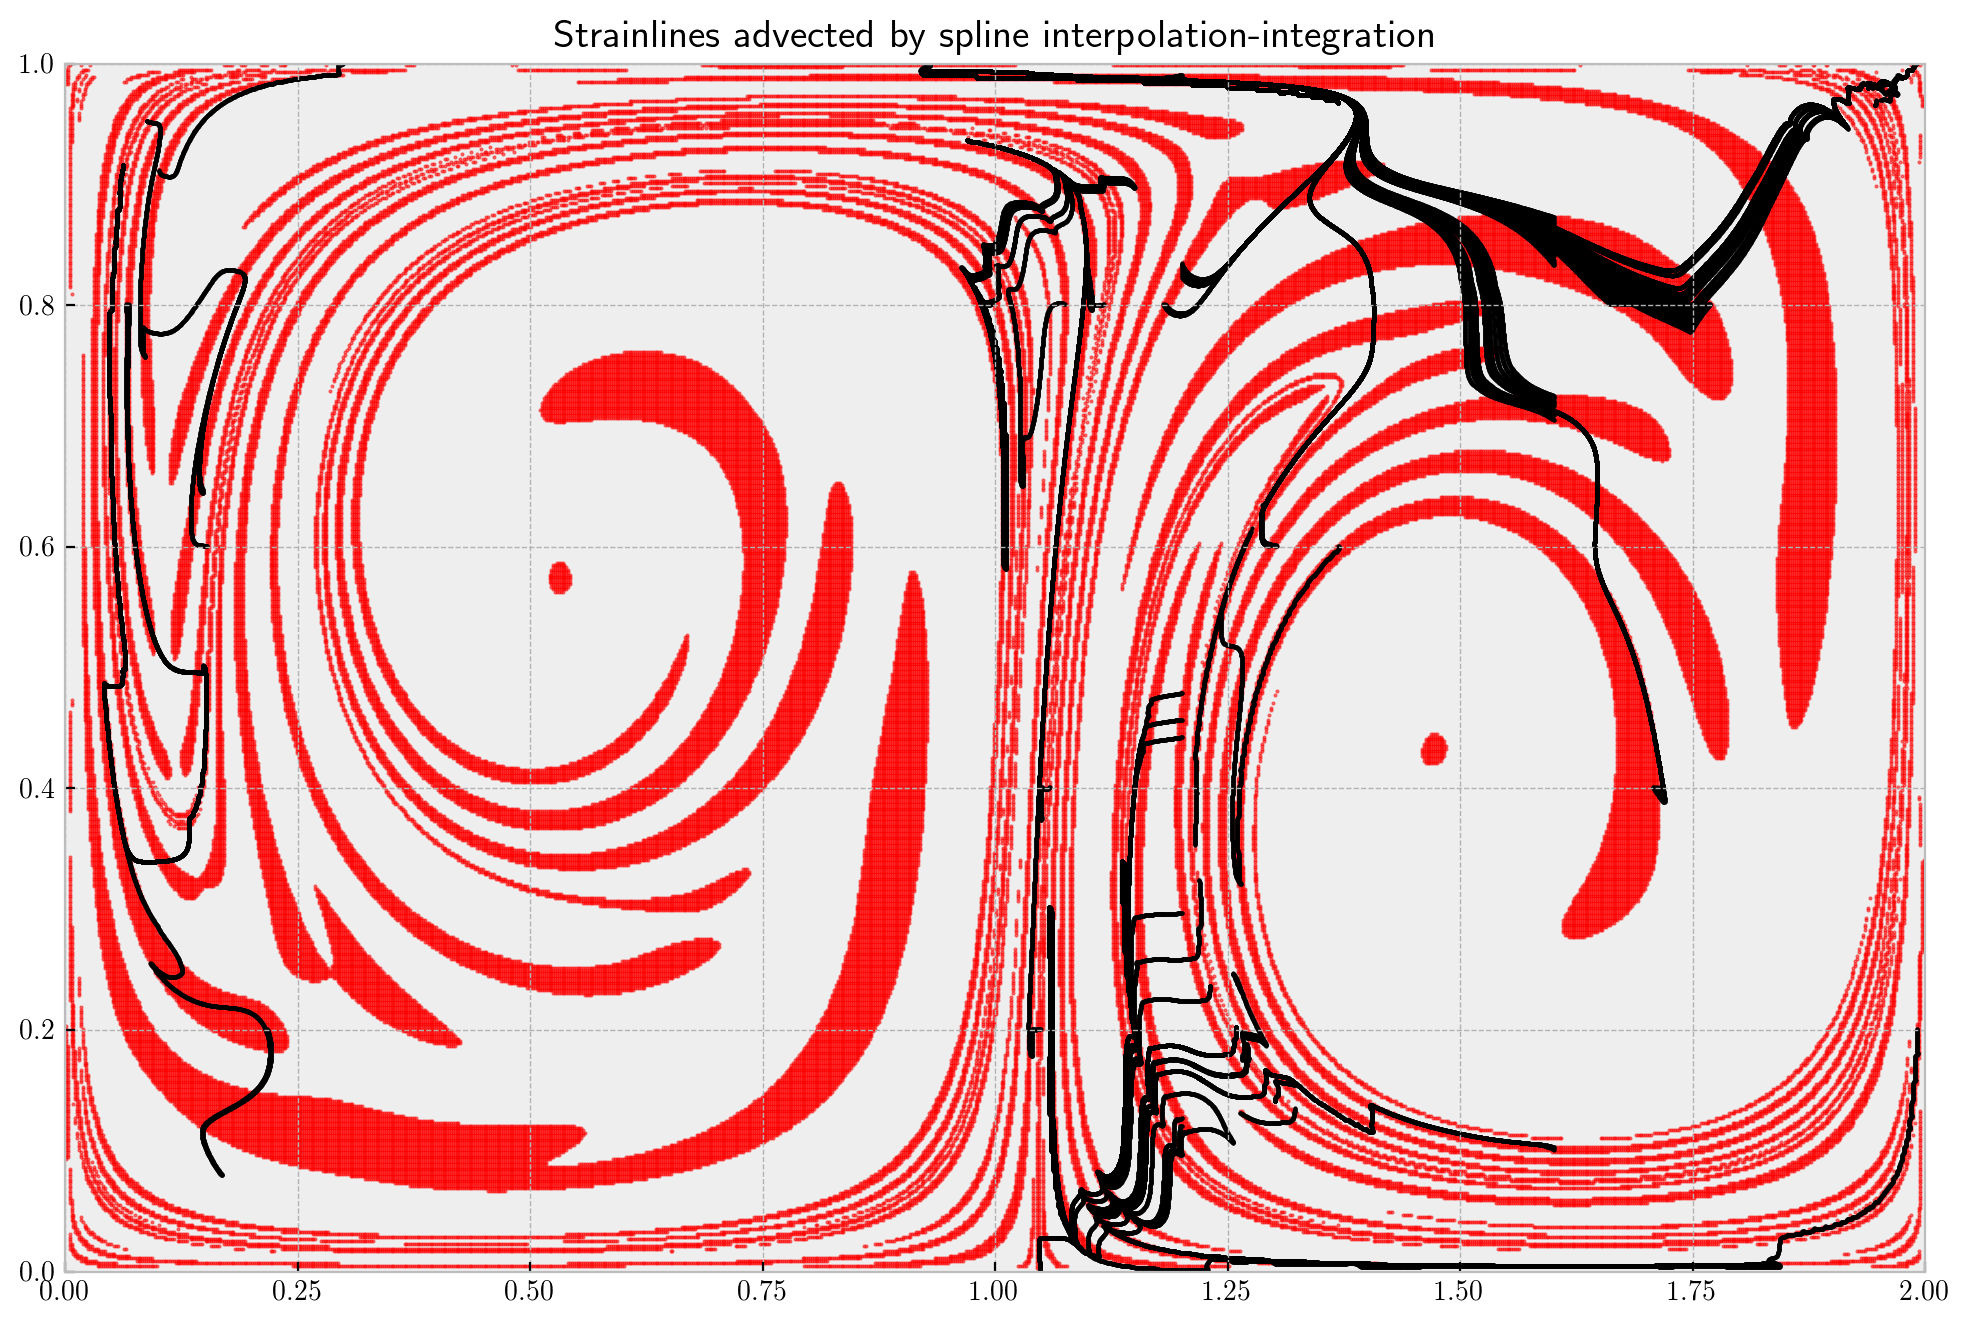

In [290]:
plt.figure(figsize = (12, 8), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], s = 1, color = 'r', alpha = 0.5)
for strainline in strainlines:
    if strainline.is_strainline():
        
        plt.scatter(strainline.get_entire_trajectory()[:,0], strainline.get_entire_trajectory()[:,1], color = 'k', s = 1)

plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Strainlines advected by spline interpolation-integration')

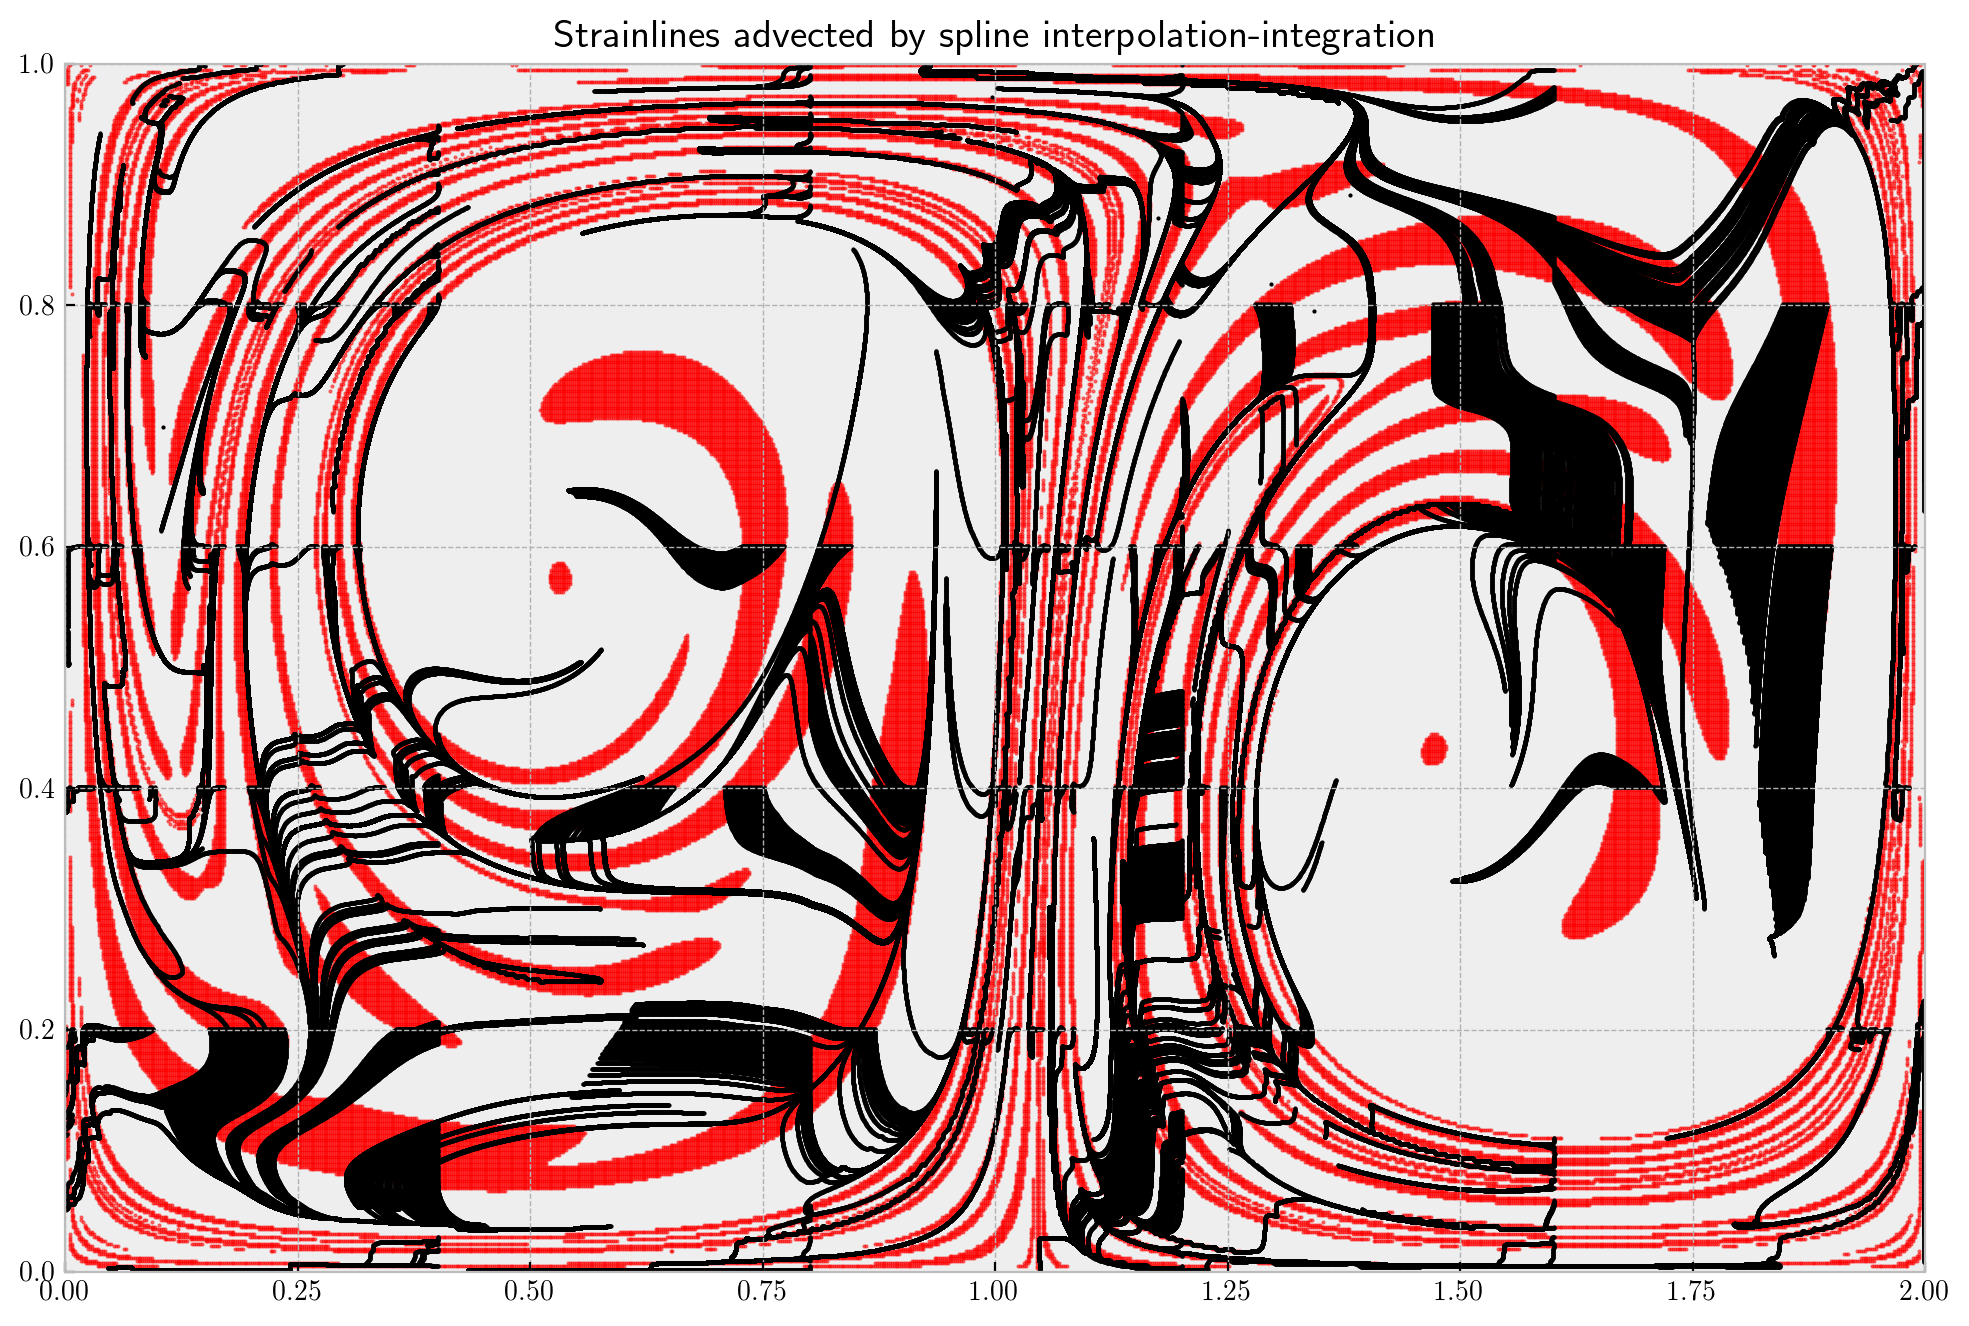

In [289]:
plt.figure(figsize = (12, 8), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], s = 1, color = 'r', alpha = 0.5)
for strainline in strainlines:
    #if strainline.is_long_enough:
        
        plt.scatter(strainline.get_entire_trajectory()[:,0], strainline.get_entire_trajectory()[:,1], color = 'k', s = 1)

plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Strainlines advected by spline interpolation-integration')

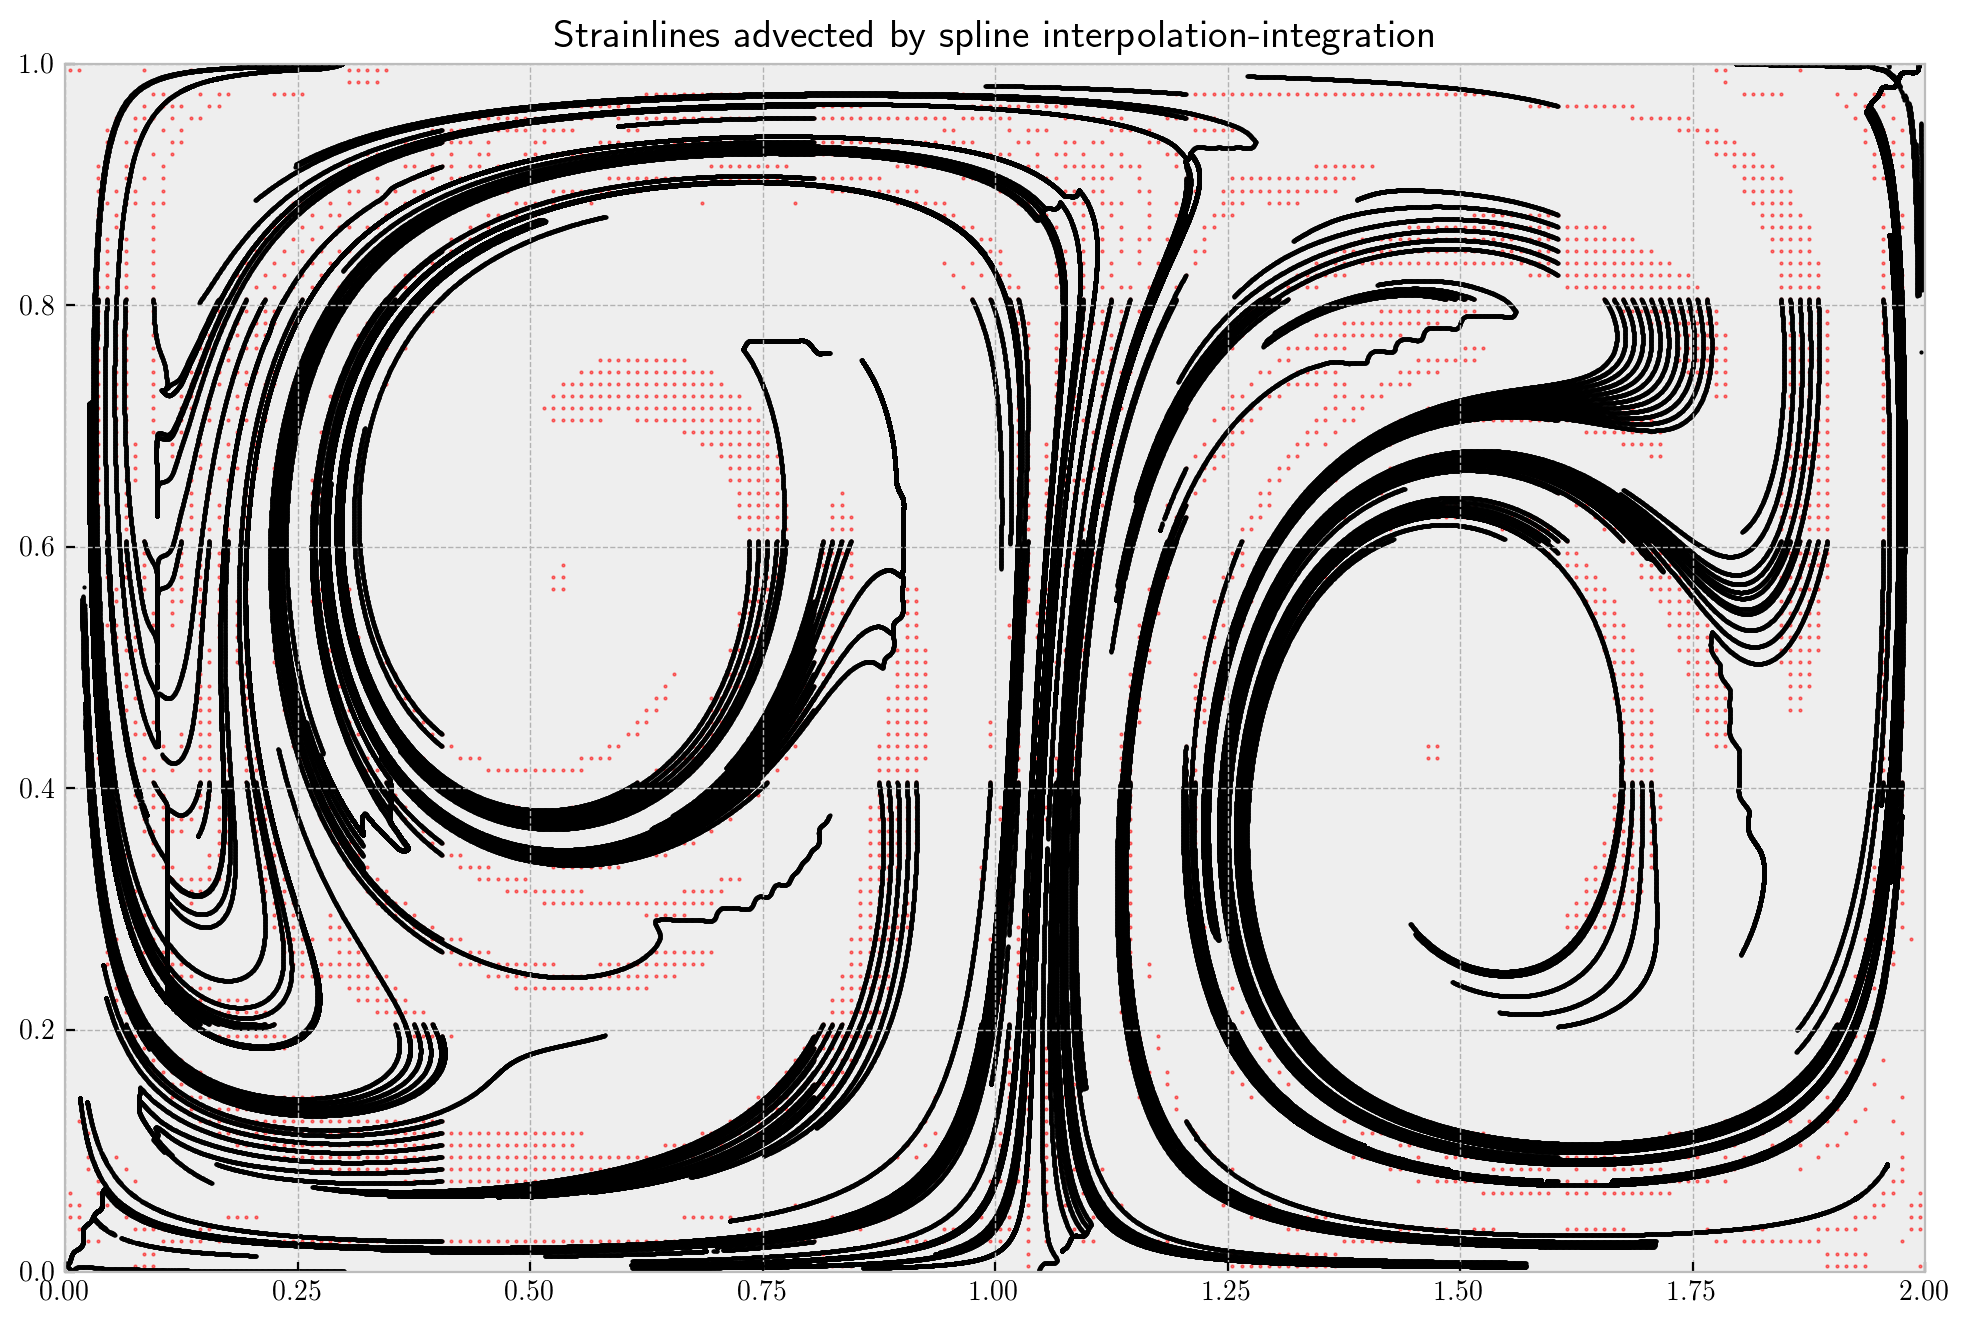

In [318]:
plt.figure(figsize = (12, 8), dpi = 200)
plt.scatter(pos_init[0,np.logical_and(A_true,B_true)], pos_init[1,np.logical_and(A_true,B_true)], s = 1, color = 'r', alpha = 0.5)
for strainline in strainlines:
    #if strainline.is_long_enough:
        
        plt.scatter(strainline.get_entire_trajectory()[:,0], strainline.get_entire_trajectory()[:,1], color = 'k', s = 1)

plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Strainlines advected by spline interpolation-integration')

In [ ]:
T = 10.
t = 0.
h = 0.1

foo = Rescaled(lambda1_spline, lambda2_spline, xi1_x_x_spline, xi1_y_spline)

G = np.copy(G_0)


ts = np.ones(np.shape(G)[1]) * t
hs = np.ones(np.shape(G)[1]) * h



traj = []

integration_mask = np.less(ts, T)

#for i in range(int((T-t)/h)):
while np.any(integration_mask):
    traj.append(G)
    foo.f_old = foo(ts[integration_mask], G[:,integration_mask])
    hs[integration_mask] = np.minimum(hs[integration_mask], T - ts[integration_mask])
    ts[integration_mask], G[:, integration_mask], hs[integration_mask] = integrator(ts[integration_mask], G[:, integration_mask], hs[integration_mask], foo, tol, tol)
    #G[:, integration_mask] = tm
    integration_mask = np.less(ts, T)
    #traj.append(G)
    #print(np.sum(integration_mask))

(0, 1)

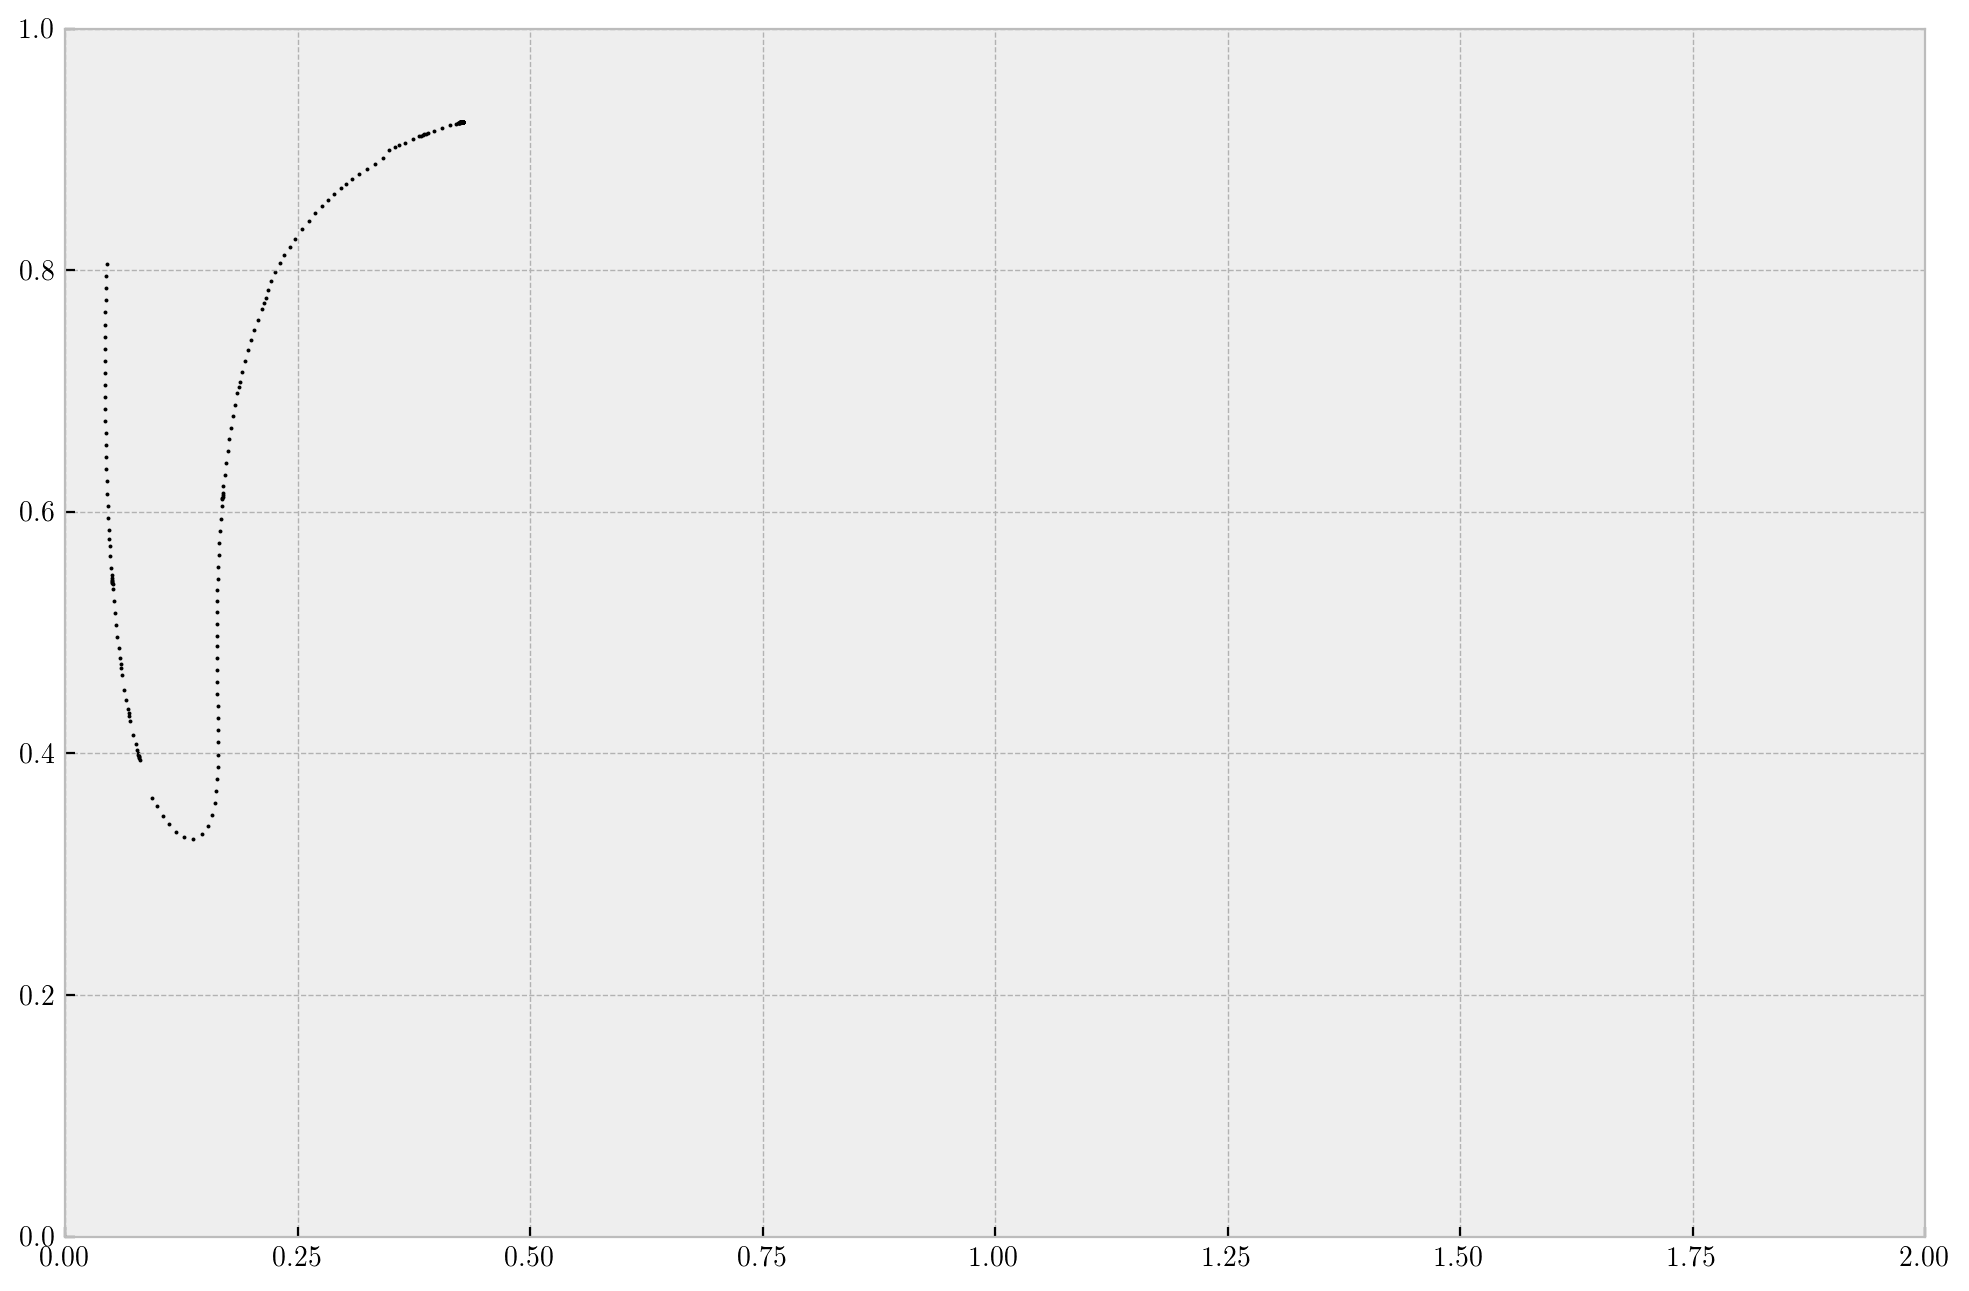

In [66]:
j = 1
plt.figure(figsize = (12,8), dpi = 200)
plt.scatter(real_candidates[j].get_entire_trajectory()[:,0], real_candidates[j].get_entire_trajectory()[:,1], s = 2, lw = 0, c = 'k')
plt.xlim(0,2)
plt.ylim(0,1)

In [83]:
idx = np.argwhere(np.diff(np.sign(real_candidates[j].get_entire_trajectory()[:,1] - 0.4)) != 0).reshape(-1)

In [84]:
idx

array([53, 73])

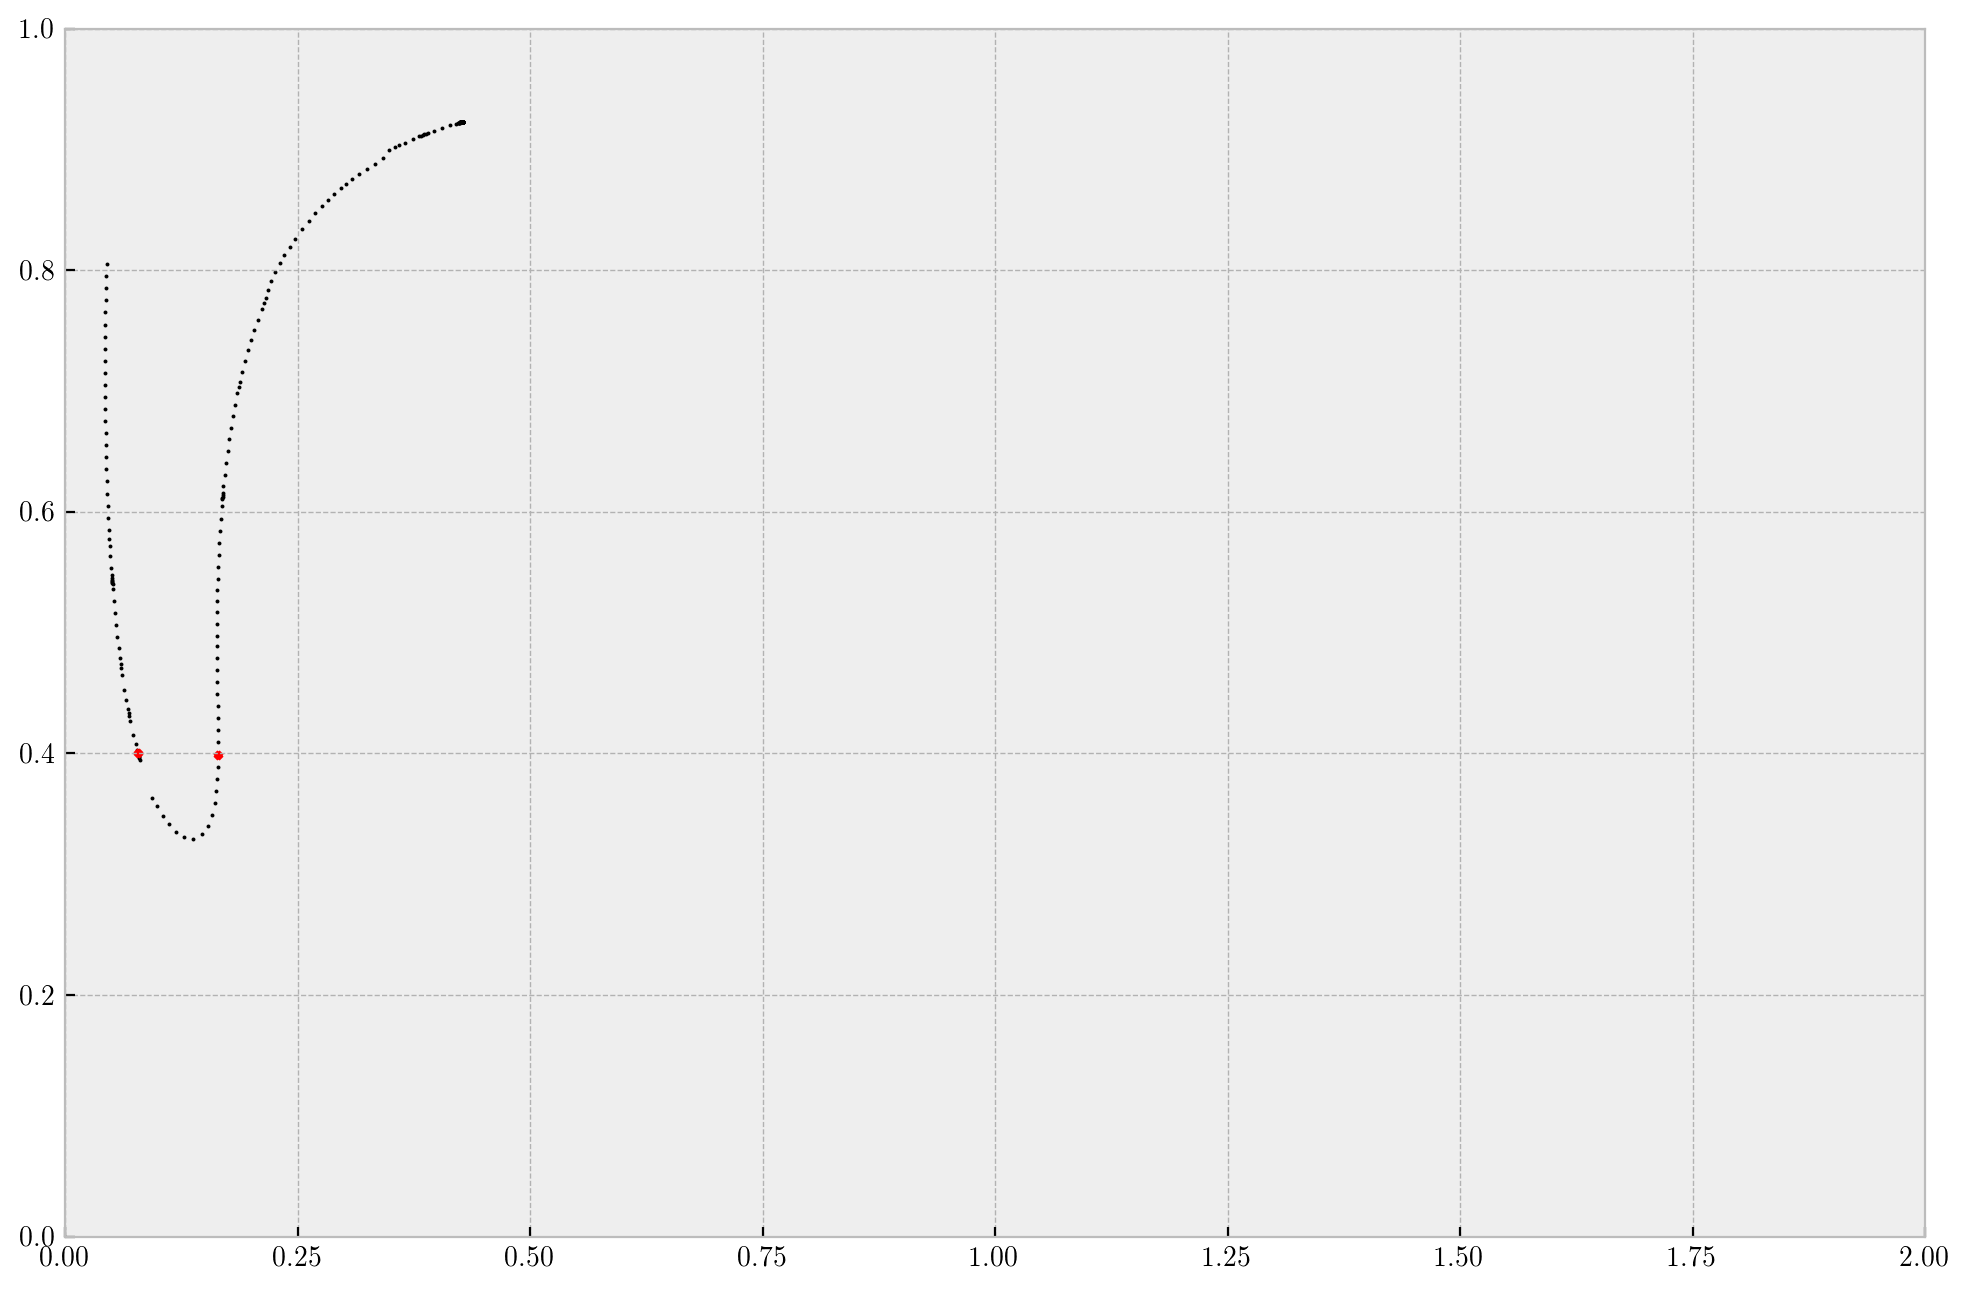

In [85]:
plt.figure(figsize=(12,8), dpi = 200)
plt.scatter(real_candidates[j].get_entire_trajectory()[:,0], real_candidates[j].get_entire_trajectory()[:,1], s = 2, lw = 0, c = 'k')
plt.scatter(real_candidates[j].get_entire_trajectory()[idx,0], real_candidates[j].get_entire_trajectory()[idx,1], marker = 'x', s = 5, c = 'r')
plt.xlim(0,2)
plt.ylim(0,1)
plt.show()



In [87]:
real_candidates[j].get_entire_trajectory()[idx,0]

array([ 0.07834833,  0.16431307])

In [81]:
idy = np.argwhere(np.diff(np.sign(real_candidates[j].get_entire_trajectory()[:,1] - 0.2)) !=0).reshape(-1)

In [88]:
np.size(idy)

0

In [151]:
locally_largest = np.ones(np.size(real_candidates), dtype=np.bool)
d_max = 0.1
vertz = np.arange(1,5) * 0.4
horz = np.arange(1,5) * 0.2

for i, xvert in enumerate(vertz):
    idx = [[] for j in range(np.size(real_candidates))]
    for j, cand in enumerate(real_candidates):
        if locally_largest[j]:
            idx[j].append(np.argwhere(np.diff(np.sign(cand.get_entire_trajectory()[:,0] - xvert)) != 0 ).reshape(-1))
            
    for j, xdi in enumerate(idx):
        if locally_largest[j]:
            for jdx in xdi:
                a = 1#print(jdx)
                

(0, 1)

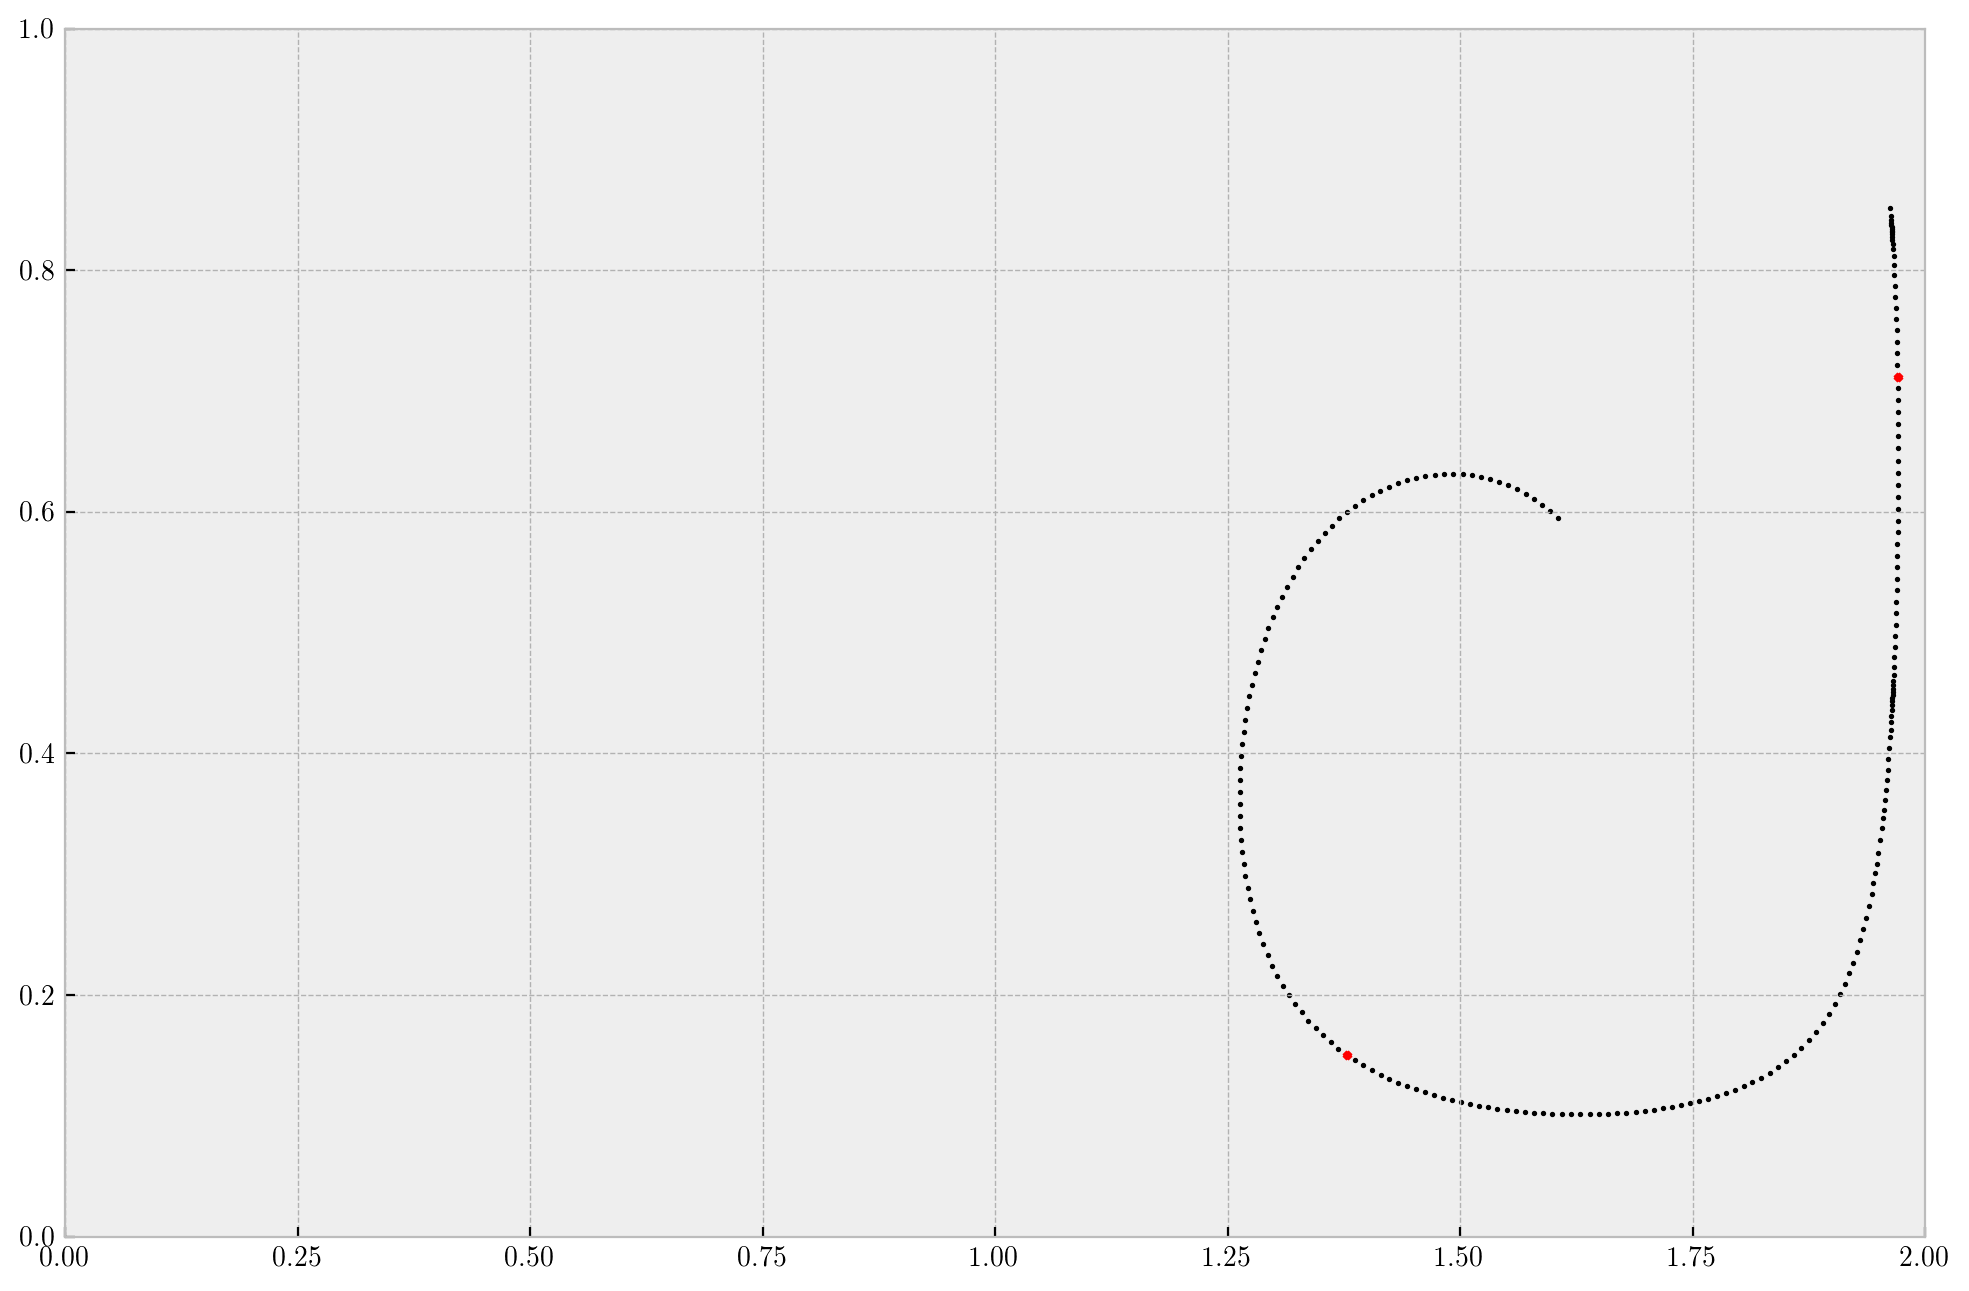

In [208]:
plt.figure(figsize = (12,8), dpi = 200)
for j in range(16,17):
    if locally_largest[j]:
        plt.scatter(real_candidates[j].get_entire_trajectory()[:,0], real_candidates[j].get_entire_trajectory()[:,1], s = 2, c = 'k')

        plt.scatter(real_candidates[j].get_entire_trajectory()[idx[j][0],0], real_candidates[j].get_entire_trajectory()[idx[j][0],1], s = 5, c = 'r', marker = 'x')
plt.xlim(0,2)
plt.ylim(0,1)

In [201]:
idx[16]

[array([ 77, 197])]

In [206]:
real_candidates[16].get_entire_trajectory()[idx[16][0][1], 0]

1.970385613189388

In [ ]:
plt.figure(figsize = (8,6), dpi = 200)
t2 = np.asarray(traj)

#plt.spy(B_true[:, ::-1].T)
#plt.spy(one_mask_to_rule_them_all[:,::-1].T)
for j in range(np.shape(t2)[2]):
    plt.plot(t2[:,0,j], t2[:,1,j], c = 'k', lw = 1, alpha = 0.5)

plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

In [ ]:
one_mask_to_rule_them_all.shape

## Using special-purpose linear interpolation:

In [ ]:
class LinearSpecial():
    def __init__(self, xc, yc, xi):
        self.xc = xc
        self.yc = yc
        self.dx = xc[-1]- xc[-2]
        self.dy = yc[-1] - yc[-2]
        self.xi = xi
        self.Nx = np.size(xc)
        self.Ny = np.size(yc)
        self.fold = None
        #print(np.shape(xi))
        #print(np.shape(self.xi))
        
    def __call__(self, t, x):
        # Calculate indices for lower left corner in cell:
        i = int(x[0]/self.dx)
        j = int(x[1]/self.dy)
        
        # If outside the domain, move inside:
        i = np.minimum(i, Nx - 2)
        j = np.minimum(j, Ny - 2)
        
        # Use the lower left corner as reference, calculate 
        # the rotation of the other vectors, and rotate by
        # 180 degrees if necessary (due to oriental 
        # discontinuity)
        subxi = np.zeros((2, 2, 2))
        subxi[:] = self.xi[:, i:i+2, j:j+2]
        
        #print(np.shape(self.xi[:, i:i+2, j:j+2]))
        
        for n in range(2):
            for m in range(2):
                if np.logical_and(np.equal(n,m), np.equal(n,0)):
                    pass
                else:
                    # Flip direction if dot product is negative
                    subxi[:,n,m] = np.sign(np.dot(subxi[:,0,0], subxi[:,n,m])) * subxi[:,n,m]
                    
        # Linear interpolarion:
        W = np.zeros((1,2,2))
        W[0,0,0] = self.xc[i+1] - x[0]
        W[0,0,1] = 1 - W[0,0,0]
        W[0,1,0] = self.yc[j+1] - x[1]
        W[0,1,1] = 1 - W[0,1,0]
        
        V = np.sum(W * subxi, axis = (1,2))
        
        V /= np.sqrt(V[0]**2 + V[1]**2)
        
        # Check orientation against previous vector:
        if self.fold is None:
            return V
        else:
            # If dot product is negative, flip sign:
            return np.sign(np.dot(self.fold, V)) * V

In [ ]:
bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

r = 0.01

LCSs = []

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

for i in range(Nx):
    if (not np.mod(i+1,100)):
        print('{}th of {} rows'.format(i, Nx))
    #progressbar.value = i
    for j in range(Ny):
        if np.logical_and(A_true, B_true)[i,j]:
            
            # Re-initialize the derivative function:
            bar.fold = None
            
            dists = np.sum((pos_init[:,i,j].reshape(2,1,1) - pos_init)**2, axis = 0)
            if np.less(evals[0,i,j], np.amax(evals[0,:,:][np.less(dists, r)])):
                pass
            else:
                T = 5
                t = 0
                h = 0.0001
                Nt = int((T-t)/h)
                
                l_min = 1
                l = 0
                
                l_filter = 0.2
                l_out = 0
                
                xs = np.zeros((2, Nt))
                xs[:,0] = pos_init[:, i, j]
                
                for n in range(1, Nt):
                    bar.fold = bar(t, xs[:, n-1])
                    t, tmp, h = rk4(t, xs[:, n-1], h, bar)
                    xs[:, n] = tmp
                    if np.greater(ABspline.ev(tmp[1], tmp[0]), 1e-2):
                        l_out += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                    else:
                        l_out = 0
                    
                    if l_out > l_filter or np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
                        break
                    l += np.sqrt((xs[0,n] - xs[0,n-1])**2 + (xs[1,n] - xs[1,n-1])**2)
                
                if np.greater(l, l_min):
                    LCSs.append(xs[:,:n])
                    print(len(LCSs))
                #print(i*Nx + j)

In [ ]:
ABspline = RectBivariateSpline(pos_init[1,0,:], pos_init[0,:,0], np.logical_and(A_true, B_true).T)
ABspline.ev(pos_init[1,0,0], pos_init[0,0,0])

In [ ]:
#bar = LinearSpecial(pos_init[0,:,0], pos_init[1,0,:], evecs[:,1,:,:])

# Loop over all initial conditions
# If (A and B), check if point 
# corresponds to a local max.
# of lambda_2 (largest eigval)

#r = 0.01

#LCSs = []

#eigenvals_in_G_0 = evals[0,one_mask_to_rule_them_all]

#progressbar = FloatProgress(min = 0, max = Nx)
#display(progressbar)

#for i in range(G_0.shape[1]):
    #progressbar.value = i
    #for j in range(Ny):
        #if one_mask_to_rule_them_all[i,j]:
            
    # Re-initialize the derivative function:
#    bar.fold = None
            
#    dists = np.sum((G_0[:,i].reshape(2,1,1) - pos_init)**2, axis = 0)
#    if np.less(eigenvals_in_G_0[i], np.amax(evals[0,:,:][np.less(dists, r)])):
        #print(i)
#        pass
        
#    else:
#        T = 5
#        t = 0
#        h = 0.0001
#        Nt = int((T-t)/h)
                
#        xs = np.zeros((2, Nt))
#        xs[:,0] = G_0[:,i]
                
#        for n in range(1, Nt):
#            bar.fold = bar(t, xs[:, n-1])
#            t, tmp, h = rk4(t, xs[:, n-1], h, bar)
#            xs[:, n] = tmp
#            if np.logical_or(np.logical_or(np.less(xs[0,n], 0.), np.greater(xs[0,n], 2.)), np.logical_or(np.less(xs[1,n], 0.), np.greater(xs[1,n], 1.))):
#                break
                
#        LCSs.append(xs[:,:n])
#        print(len(LCSs))
        #print(i*Nx + j)

In [ ]:
np.amax(evals[0,:,:][dists < r])

In [ ]:
plt.figure(figsize = (16, 10))

for i in range(len(LCSs)):
    plt.plot(LCSs[i][0,:], LCSs[i][1,:], c = 'k', lw = 1)
    
plt.xlim([-0.1, 2.1])
plt.ylim([-0.1, 1.1])

plt.tight_layout()

In [ ]:
plt.figure(figsize = (16,10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(evals[1] + 1))

In [ ]:
plt.figure(figsize = (16, 10), dpi = 200)
plt.pcolormesh(pos_init[0], pos_init[1], np.log(smallest_eval_spline.ev(pos_init[1], pos_init[0]) + 1) )

In [ ]:
np.shape(G_0)

In [ ]:
plt.figure(figsize=(12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,0,:,:], evecs[1,0,:,:])
plt.title('Largest')

In [ ]:
plt.figure(figsize = (12,8), dpi = 200)
plt.quiver(pos_init[0], pos_init[1], evecs[0,1,:,:], evecs[1,1,:,:])
plt.title('Largest')

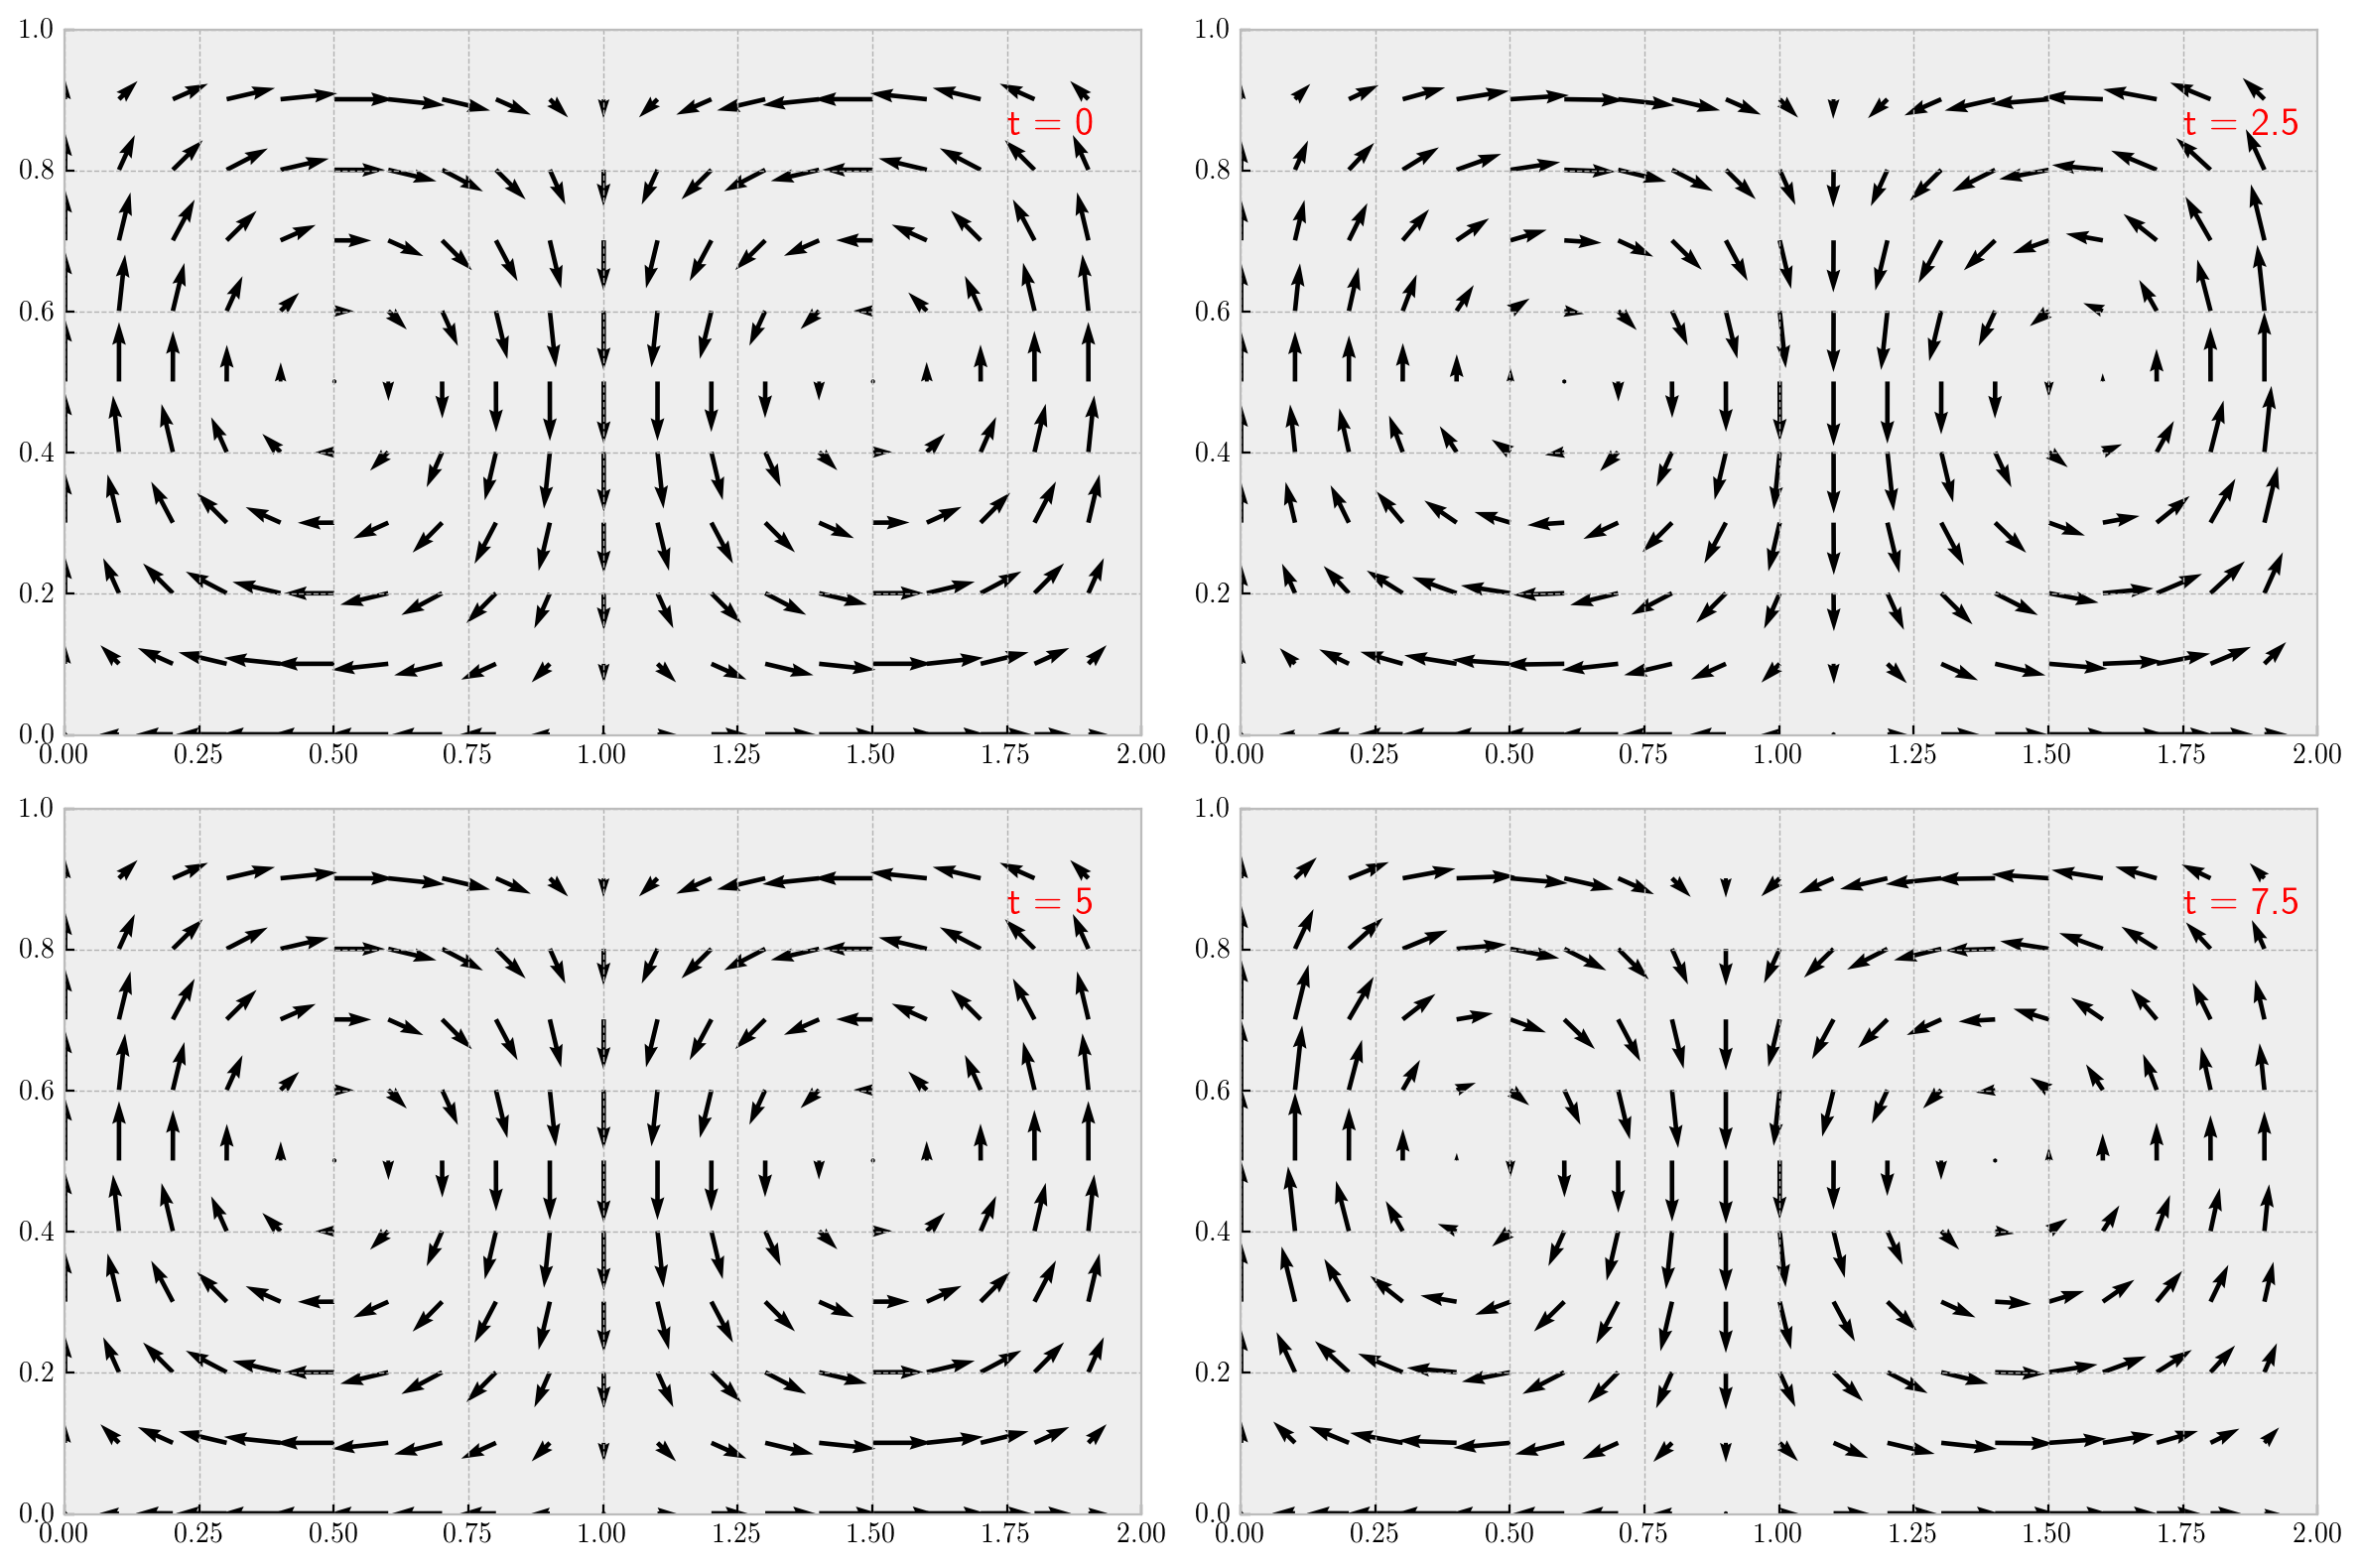

In [291]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8), dpi = 200)
ax1.quiver(pos_init[0][::50, ::50], pos_init[1][::50, ::50], vel(0, pos_init)[0][::50, ::50], vel(0, pos_init)[1][::50, ::50])
ax1.text(1.75, 0.85, 't = 0', color = 'red', size = 14)
ax1.set_xlim(0,2)
ax1.set_ylim(0,1)
ax2.quiver(pos_init[0][::50, ::50], pos_init[1][::50, ::50], vel(2.5, pos_init)[0][::50, ::50], vel(2.5, pos_init)[1][::50, ::50])
ax2.text(1.75, 0.85, 't = 2.5', color = 'red', size = 14)
ax2.set_xlim(0,2)
ax2.set_ylim(0,1)
ax3.quiver(pos_init[0][::50, ::50], pos_init[1][::50, ::50], vel(5, pos_init)[0][::50, ::50], vel(5, pos_init)[1][::50, ::50])
ax3.text(1.75, 0.85, 't = 5', color = 'red', size = 14)
ax3.set_xlim(0,2)
ax3.set_ylim(0,1)
ax4.quiver(pos_init[0][::50, ::50], pos_init[1][::50, ::50], vel(7.5, pos_init)[0][::50, ::50], vel(7.5, pos_init)[1][::50, ::50])
ax4.text(1.75, 0.85, 't = 7.5', color = 'red', size = 14)
ax4.set_xlim(0,2)
ax4.set_ylim(0,1)
plt.tight_layout()